In [1]:
import sys
sys.path.append('C:/Users/Fabian/gempy')
#sys.path.insert(1,'/home/bl9/gempy')
import gempy as gp

C:/Users/Fabian/gempy\gempy\plotting\visualization.py:36: UserWarning: Steno 3D package is not installed. No 3D online visualization available.
  warnings.warn('Steno 3D package is not installed. No 3D online visualization available.')


In [2]:
%matplotlib inline
import pymc
import numpy as np
import math

from IPython.core.display import Image

from pymc.Matplot import plot
from pymc import graph

from IPython.core.pylabtools import figsize
figsize(15, 6)

import scipy.optimize as sop
import scipy.stats as stats
from scipy.signal import argrelextrema

import matplotlib.mlab as mlab
from matplotlib import pyplot as plt

import importlib

from operator import itemgetter

from mpl_toolkits.mplot3d import Axes3D

import vtk
import evtk

from skimage import measure
from scipy.interpolate import griddata

import decision_making as dm

In [3]:
import gempy.utils.spill_analysis as sp
import gempy.utils.fault_analysis as fa

In [4]:
# Importing the data from csv files and setting extent and resolution
geo_data = gp.create_data([0,2000,0,2000,0,2000],[50,50,50],
                         path_o = ".././input_data/Fab_ResModel_Foliations2.csv",
                         path_i = ".././input_data/Fab_ResModel_Points4_small_offset.csv")
geo_data.n_faults = 1

C:/Users/Fabian/gempy\gempy\data_management.py:815: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  for i in self.interfaces["formation"]]
C:/Users/Fabian/gempy\gempy\data_management.py:819: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  for i in self.orientations["formation"]]


In [5]:
#p.get_data(geo_data)

In [6]:
gp.set_series(geo_data, {"fault":'MainFault', 
                      "Rest":('Base_Top', 'Res_Top', 'Seal_Top', 'SecRes_Top')},
                       order_series = ["fault","Rest",], order_formations=['MainFault', 
                                         'SecRes_Top', 'Seal_Top', 'Res_Top','Base_Top',
                                         ])

C:/Users/Fabian/gempy\gempy\data_management.py:815: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  for i in self.interfaces["formation"]]
C:/Users/Fabian/gempy\gempy\data_management.py:819: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  for i in self.orientations["formation"]]


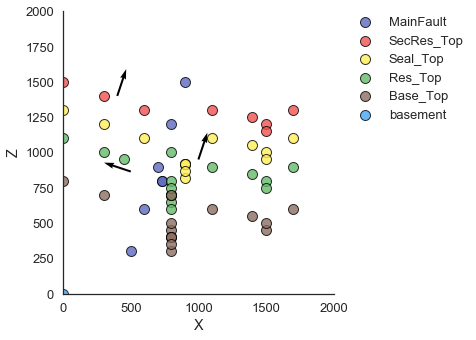

In [7]:
figsize(20,10)
#plt.savefig('points.pdf', transparent=True)
gp.plotting.plot_data(geo_data)

In [8]:
# Creating a row label 'fault side' to distinguish between footwall (FW) and hanging wall (HW)
def set_fault_sides(geo_data, fault_border, fault_name):
    geo_data.interfaces['fault side'] = 'nan'
    HW_border = fault_border # distance of middle of fault (border HW/FW) from footwall border of model
                # (X = 2000 - 1300 = 700)
    nonfault_cond = geo_data.interfaces['formation'] != fault_name
    fault_cond = geo_data.interfaces['formation'] == fault_name

    fw_x_cond = geo_data.interfaces['X'] > (geo_data.extent[:2][1] - HW_border) # condition for FW points

    hw_x_cond = geo_data.interfaces['X'] < (geo_data.extent[:2][1] - HW_border) # condition for HW points

    geo_data.interfaces.loc[fw_x_cond,'fault side'] = 'footwall' # setting FW
    geo_data.interfaces.loc[hw_x_cond,'fault side'] = 'hanging wall' #setting HW
    geo_data.interfaces.loc[fault_cond,'fault side'] = 'nan'; # reverting fault points to 'nan'
    return geo_data

In [9]:
geo_data = set_fault_sides(geo_data, 1300, 'MainFault')

In [10]:
# INTERPOLATION
interp_data = gp.InterpolatorData(geo_data, u_grade = [1, 1], output='gradients', dtype ='float64',
                                 compile_theano=True)

C:/Users/Fabian/gempy\gempy\interpolator.py:206: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  [geo_data.orientations, geo_data.interfaces]).max()[['X', 'Y', 'Z']]
C:/Users/Fabian/gempy\gempy\interpolator.py:208: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  [geo_data.orientations, geo_data.interfaces]).min()[['X', 'Y', 'Z']]
C:/Users/Fabian/gempy\gempy\interpolator.py:243: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  geo_data_rescaled.extent = copy.copy(new_coord_extent.as_matrix())
C:/Users/Fabian/gempy\gempy\int

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  1


In [11]:
# COMPUTATION OF THE MODEL
lith_sol, fault_sol = gp.compute_model(interp_data)

C:/Users/Fabian/gempy\gempy\interpolator.py:777: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  dips_position = self.geo_data_res_no_basement.orientations[['X', 'Y', 'Z']].as_matrix()
C:/Users/Fabian/gempy\gempy\interpolator.py:778: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  dip_angles = self.geo_data_res_no_basement.orientations["dip"].as_matrix()
C:/Users/Fabian/gempy\gempy\interpolator.py:779: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  azimuth = self.geo_data_res_no_basement.orientations["azimuth"].as_matrix()
C:/Users/Fabian/gempy\gempy\interpolator.py:780: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  polarity = self.geo_data_res_no_basement.orientations["polarity"].as_matrix()
C:/Users/Fabian/gempy\gempy\interpolator.py:781: FutureWarning: Method .as_matrix will be removed in a future versi

In [12]:
# Arrays to hold the original compuation of the model
# These is used in case of computation failure (singular matrix) during modeling under uncertainty
lith_holder = lith_sol
fault_holder = fault_sol
interp_holder = interp_data

In [13]:
# Geo formation numbers
base_n = geo_data.formations.loc['basement','formation_number']
res_n = geo_data.formations.loc['Base_Top','formation_number']
seal_n = geo_data.formations.loc['Res_Top','formation_number']
secres_n = geo_data.formations.loc['Seal_Top','formation_number']
over_n = geo_data.formations.loc['SecRes_Top','formation_number']
fault_n = geo_data.formations.loc['MainFault','formation_number']

In [14]:
# CREATING SURFACES FOR LAYER INTERFACES (vertices and simplices; interfaces named as bottoms of layers)
res_surf_v, res_surf_s = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], 
                                         potential_fault=None, n_formation = res_n)
seal_surf_v, seal_surf_s = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], 
                                           potential_fault=None, n_formation = seal_n)
secres_surf_v, secres_surf_s = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], 
                                               potential_fault=None, n_formation = secres_n)
over_surf_v, over_surf_s = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], 
                                           potential_fault=None, n_formation = over_n)

fault_surf_v, fault_surf_s = gp.get_surfaces(interp_data = 
                                             interp_data, potential_lith=None, potential_fault=fault_sol[1], 
                                             n_formation = fault_n)

In [15]:
plot_3Dpoints = False
plot_3Dsurf = False

if plot_3Dpoints:
    # 3D plot points in VTK
    gp.plot_data_3D(geo_data)
elif plot_3Dsurf:
    # 3D plot points and surfaces in VTK
    gp.plot_surfaces_3D(geo_data, [res_surf_v, seal_surf_v, secres_surf_v, over_surf_v], 
                    [res_surf_s, seal_surf_s, secres_surf_s, over_surf_s], plot_data=True
                   )

In [16]:
# DECLARING SOME MODEL VARIABLES
resolution = geo_data.resolution[1] #resolution, standard: 50
model_size = geo_data.extent[:2][1] # 'real' model extent, here: 2000 m - cubic (what if not cubic?)
scale_factor = (model_size/resolution) # scale factor used for calculating voxel volumes in [m]
                                        # here: 2000/50 = 40
rescale_f = interp_data.rescaling_factor # rescaling factor from geo_data to interp_data

minmax_buffer = True # buffer around local min and max values [on/off] - not used atm

SSF_c = 3

In [17]:
vox_size_x = np.abs(geo_data.extent[1] - geo_data.extent[0]) / geo_data.resolution[0]
vox_size_y = np.abs(geo_data.extent[3] - geo_data.extent[2]) / geo_data.resolution[1]
vox_size_z = np.abs(geo_data.extent[5] - geo_data.extent[4]) / geo_data.resolution[2]
vox_size_diag = np.sqrt(vox_size_x ** 2 + vox_size_y ** 2 + vox_size_z ** 2)

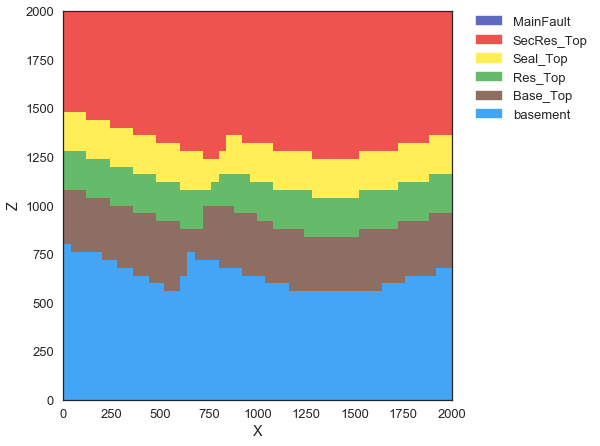

In [18]:
#%matplotlib notebook
%matplotlib inline
figsize(20,10)
gp.plotting.plot_section(geo_data, lith_sol[0], int(resolution/2), plot_data=0)
#plt.savefig('computed_block.pdf', transparent=True)

In [19]:
GX,GY,GZ=lith_sol[2].reshape(resolution,resolution,resolution), lith_sol[3].reshape(resolution,resolution,resolution), lith_sol[4].reshape(resolution,resolution,resolution)

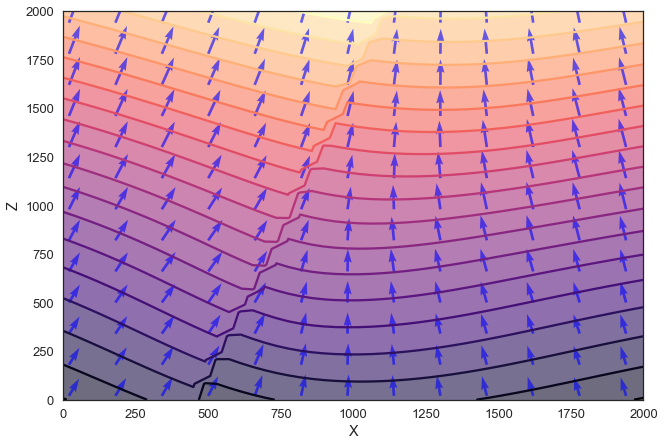

In [20]:
gp.plot_gradient(geo_data, lith_sol[1], GX, GY, GZ, 5, direction='y', quiver_stepsize=4)

In [21]:
intersect_minima_all, intersect_maxima_all, intersect_saddles_all = sp.get_surface_extrema(geo_data,seal_surf_v,GX,GY,ref='x')

No maxima found for surface.


No maxima found for surface.


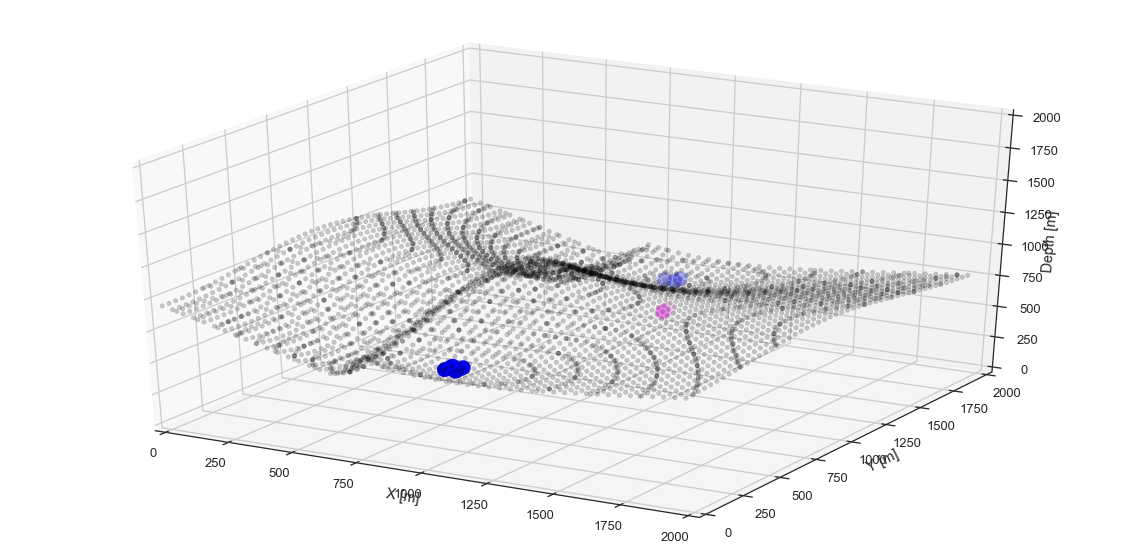

In [22]:
figsize(20,10)
sp.plot_surface_extrema(geo_data,seal_surf_v,GX,GY,ref='x')

In [23]:
gradmin = sp.get_gradient_minima(geo_data,GX,GY, ref='mean')
intersect = sp.get_gradmin_intersect(geo_data,seal_surf_v,gradmin) 

In [24]:
from scipy.spatial import distance

In [25]:
np.max(GZ)

0.9157888293266296

In [26]:
v_gz0, s_gz, n_gz, val_gz = measure.marching_cubes_lewiner(GZ, 0.8)

In [27]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

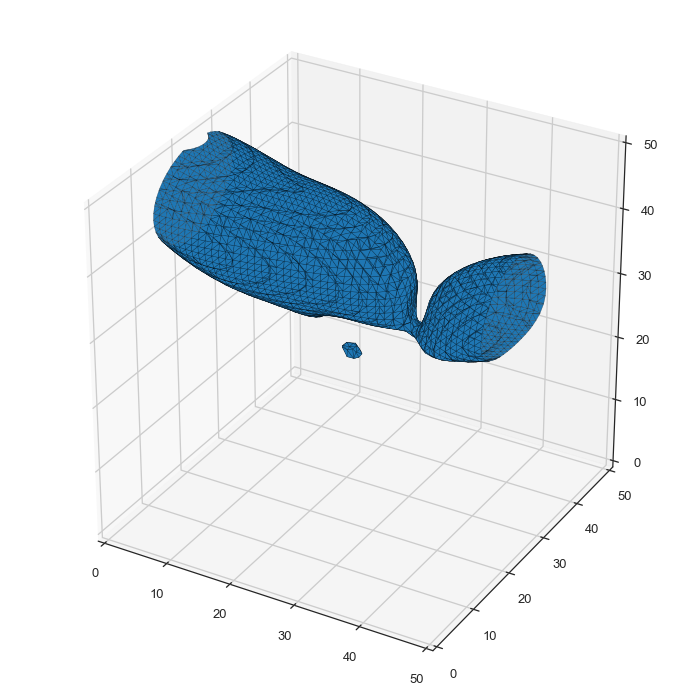

In [28]:
# 3D visualization of both surfaces attained via marching cubes
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(v_gz0[s_gz], alpha=0.5)
mesh.set_edgecolor('k')

ax.add_collection3d(mesh)

ax.set_xlim(0, resolution)  # a = 6 (times two for 2nd ellipsoid)
ax.set_ylim(0, resolution)  # b = 10
ax.set_zlim(0, resolution)  # c = 16

plt.tight_layout()
plt.show()

In [29]:
gz = np.copy(GZ)
cond_z = GZ >= 0.8
gz[~cond_z] = False

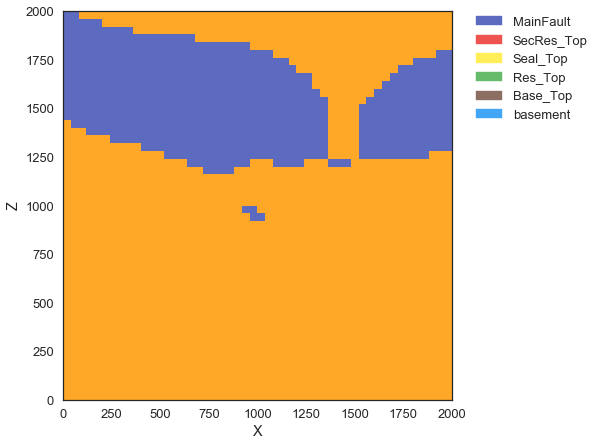

In [30]:
gp.plotting.plot_section(geo_data, gz, 25, direction='y')

In [ ]:
v_l = seal_surf_v
v_l2 = res_surf_v
v_f = fault_surf_v[0]

#cutting layer surface vertices (v_l) down to maximal extent of fault surface (v_f)
f_x_extent = np.array([np.min(v_f[:,0]), np.max(v_f[:,0])])
f_y_extent = np.array([np.min(v_f[:,1]), np.max(v_f[:,1])])
f_z_extent = np.array([np.min(v_f[:,2]), np.max(v_f[:,2])])

x_cond1 = v_l[:,0] >= f_x_extent[0] 
x_cond2 = v_l[:,0] <= f_x_extent[1]
x_cond = np.logical_and(x_cond1,x_cond2)

y_cond1 = v_l[:,1] >= f_y_extent[0] 
y_cond2 = v_l[:,1] <= f_y_extent[1]
y_cond = np.logical_and(y_cond1,y_cond2)

z_cond1 = v_l[:,2] >= f_z_extent[0] 
z_cond2 = v_l[:,2] <= f_z_extent[1]
z_cond = np.logical_and(z_cond1,z_cond2)

xyz_cond = np.logical_and(z_cond, np.logical_and(x_cond,y_cond))

v_cut = v_l[xyz_cond]

#find intersection between layer and fault surface
fl_dist = distance.cdist(v_cut, v_f)
min_dist = np.min(fl_dist, axis=0)
fl_cut_bool = min_dist < (vox_size_diag/2)
fault_intersect = v_f[fl_cut_bool]

#find intersection between layer and fault surface 2
fl_dist = distance.cdist(v_f, v_cut)
min_dist = np.min(fl_dist, axis=0)
fl_cut_bool = min_dist < (vox_size_diag/2)
fault_intersect2 = v_cut[fl_cut_bool]

In [ ]:
def get_lith_fault_intersect(v_f,v_l):
    #cutting layer surface vertices (v_l) down to maximal extent of fault surface (v_f)
    f_x_extent = np.array([np.min(v_f[:,0]), np.max(v_f[:,0])])
    f_y_extent = np.array([np.min(v_f[:,1]), np.max(v_f[:,1])])
    f_z_extent = np.array([np.min(v_f[:,2]), np.max(v_f[:,2])])
    
    x_cond1 = v_l[:,0] >= f_x_extent[0] 
    x_cond2 = v_l[:,0] <= f_x_extent[1]
    x_cond = np.logical_and(x_cond1,x_cond2)
    
    y_cond1 = v_l[:,1] >= f_y_extent[0] 
    y_cond2 = v_l[:,1] <= f_y_extent[1]
    y_cond = np.logical_and(y_cond1,y_cond2)
    
    z_cond1 = v_l[:,2] >= f_z_extent[0] 
    z_cond2 = v_l[:,2] <= f_z_extent[1]
    z_cond = np.logical_and(z_cond1,z_cond2)
    
    xyz_cond = np.logical_and(z_cond, np.logical_and(x_cond,y_cond))
    
    v_cut = v_l[xyz_cond]
    
    #find intersection between layer and fault surface
    fl_dist = distance.cdist(v_cut, v_f)
    min_dist = np.min(fl_dist, axis=0)
    fl_cut_bool = min_dist < (vox_size_diag/2)
    fault_intersect = v_f[fl_cut_bool]
    holder = np.zeros_like(v_f)
    holder[fl_cut_bool] = 1
    
    fl_dist = distance.cdist(v_f, v_cut)
    min_dist = np.min(fl_dist, axis=0)
    fl_cut_bool = min_dist < (vox_size_diag/2)
    fault_intersect2 = v_cut[fl_cut_bool]
    
    return fault_intersect, fault_intersect2, holder.astype(bool)

In [ ]:
### FA MODULE TESTING
# remember: also need negative peaks (for finite faults)
fa.get_contact_peaks_vert(geo_data, lith_sol, fault_sol, lith_n=res_n,
                    fault_n=fault_n, fault_v=v_f, layer_v=v_l, projection='automatic',
                    fault_side='fw', order='automatic')
fa.plot_fault_contact_projection(geo_data, lith_sol, fault_sol, lith_n=res_n,
                    fault_n=fault_n, projection='automatic',
                    fault_side='fw')

In [ ]:
fa.get_contact_peaks_vert(geo_data, lith_sol, fault_sol, lith_n=res_n,
                    fault_n=fault_n, fault_v=v_f, layer_v=v_l, projection='automatic',
                    fault_side='hw', order=30)

In [ ]:
fa.get_faultthrow_at(geo_data, lith_sol, fault_sol, res_n, fault_n, 
                     position=5, projection='yz')

In [ ]:
fa.get_contact_peaks_vert(geo_data, lith_sol, fault_sol, lith_n=res_n,
                    fault_n=fault_n, fault_v=v_f, layer_v=v_l, projection='automatic',
                    fault_side='fw', order=50)

In [ ]:
fa.get_contact_peaks_vert(geo_data, lith_sol, fault_sol, lith_n=res_n,
                    fault_n=fault_n, fault_v=v_f, layer_v=v_l, projection='automatic',
                    fault_side='hw', order=40)

In [ ]:
peak_pos= fa.arg_contact_peaks_vox(geo_data, lith_sol, fault_sol, lith_n=res_n,
                    fault_n=fault_n, projection='automatic',
                    fault_side='fw', order=40)

In [ ]:
fa.get_contact_peaks_vox(geo_data, lith_sol, fault_sol, lith_n=res_n,
                    fault_n=fault_n, projection='automatic',
                    fault_side='fw', order=40)

In [ ]:
fa.get_faultthrow_at(geo_data, lith_sol, fault_sol, res_n, fault_n, 
                     position='faultmax_argrelmax', projection='yz', order=40)

In [ ]:
%matplotlib inline
figsize(20,20)
#seal_surf_v
#secres_surf
#over_surf_v
#fault_surf_
intersect = get_lith_fault_intersect(v_f,v_l)[0]
intersect2 = get_lith_fault_intersect(v_f,v_l)[1]
intersect_bool = get_lith_fault_intersect(v_f,v_l)[2]

intersect_minima_all, intersect_maxima_all, intersect_saddles_all \
        = sp.get_surface_extrema(geo_data, v_l, GX, GY)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(v_l[:, 0], v_l[:, 1], v_l[:, 2], color='k', alpha=0.05)
ax.scatter(v_f[:, 0], v_f[:, 1], v_f[:, 2], color='r', alpha=0.1)
#ax.scatter(gradmin[:, 0], gradmin[:, 1], gradmin[:, 2], color='k', alpha=0.2)
ax.scatter(intersect[:, 0], intersect[:, 1], intersect[:, 2], color='maroon', alpha=0.7)
ax.scatter(intersect2[:, 0], intersect2[:, 1], intersect2[:, 2], color='forestgreen', alpha=0.7)
#ax.plot(intersect[:, 0], intersect[:, 1], '+', markersize=200, color='r', zdir='z')#, zs=-2.)
#ax.plot(intersect[:, 0], intersect[:, 2], '+', markersize=200, color='g', zdir='y')#, zs=2.)
#ax.plot(intersect[:, 1], intersect[:, 2], '+', markersize=200, color='b', zdir='x')#, zs=-2.)
if len(intersect_minima_all) > 0:
    ax.scatter(intersect_minima_all[:, 0], intersect_minima_all[:, 1], intersect_minima_all[:, 2], \
               color='blue',s=200, marker='o')
if len(intersect_maxima_all) > 0:
    ax.scatter(intersect_maxima_all[:,0],intersect_maxima_all[:,1],intersect_maxima_all[:,2],\
               color='r', s=200, marker='o')
if len(intersect_saddles_all) > 0:
    ax.scatter(intersect_saddles_all[:, 0], intersect_saddles_all[:, 1], intersect_saddles_all[:, 2], \
               color='violet',s=200, marker='o')

ax.set_xlim(geo_data.extent[0], geo_data.extent[1])
ax.set_ylim(geo_data.extent[2], geo_data.extent[3])
ax.set_zlim(geo_data.extent[4], geo_data.extent[5])
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Depth [m]')
plt.show()

# Approach: Analysis over vertices

In [27]:
from numpy.linalg import svd
    
def plane_fit(point_list):
    """
    Fit plane to points in PointSet
    Fit an d-dimensional plane to the points in a point set.
    adjusted from: http://stackoverflow.com/questions/12299540/plane-fitting-to-4-or-more-xyz-points

    Args:
        point_list (array_like): array of points XYZ

    Returns:
        Return a point, p, on the plane (the point-cloud centroid),
        and the normal, n.
    """

    #     points = np.empty((3, len(point_list)))
    #     for i, point in enumerate(point_list):
    #         points[0, i] = point.x
    #         points[1, i] = point.y
    #         points[2, i] = point.z
    points = point_list


    points = np.reshape(points, (np.shape(points)[0], -1))  # Collapse trialing dimensions
    assert points.shape[0] <= points.shape[1], "There are only {} points in {} dimensions.".format(points.shape[1],
                                                                                                   points.shape[0])
    ctr = points.mean(axis=1)
    x = points - ctr[:, np.newaxis]
    M = np.dot(x, x.T)  # Could also use np.cov(x) here.
    return M

In [28]:
M = plane_fit(v_f.T)
U = svd(M)
U

(array([[ -3.16227770e-01,  -3.93127909e-17,   9.48683297e-01],
        [  3.93127909e-17,  -1.00000000e+00,  -2.83350564e-17],
        [ -9.48683297e-01,  -2.83350564e-17,  -3.16227770e-01]]),
 array([  1.19863300e+09,   1.09956000e+09,   5.11457551e-03]),
 array([[-0.31622777,  0.        , -0.9486833 ],
        [-0.        , -1.        ,  0.        ],
        [ 0.9486833 ,  0.        , -0.31622777]]))

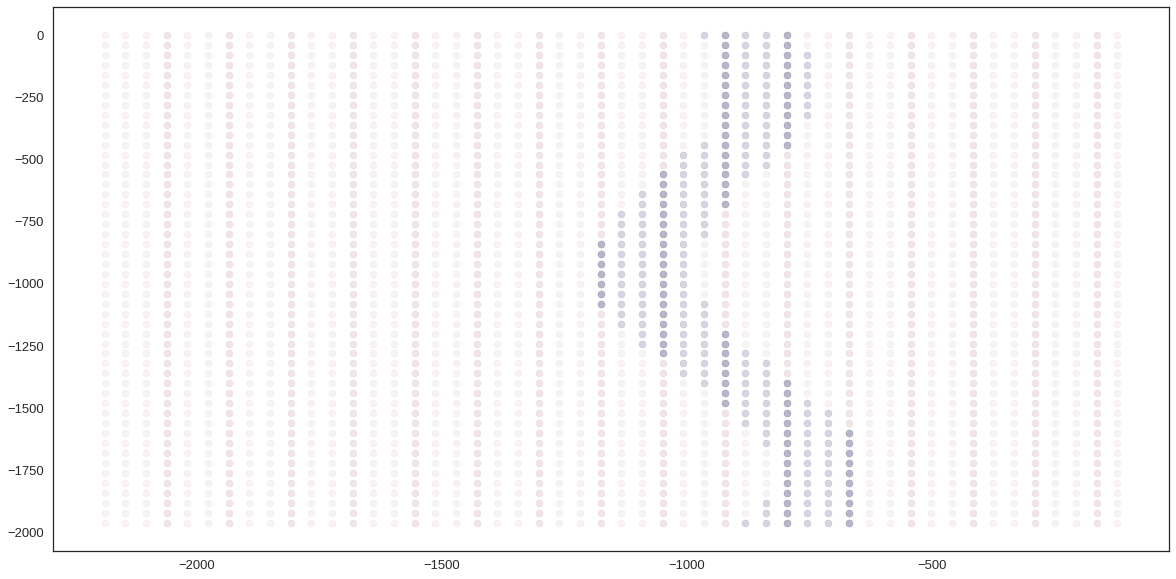

In [29]:
p=intersect
p1=v_f
p2 = intersect_bool
new = np.dot(p, U[0])
fault_rot= np.dot(p1, U[0])
bool_rot = np.dot(p2, U[0])
#fault_n = np.dot(fault[['X', 'Y', 'Z']], U[2])
%matplotlib inline
figsize(20,10)
plt.scatter(new[:, 0], new[:, 1], alpha=.2, s=50)
plt.scatter(fault_rot[:, 0], fault_rot[:, 1], alpha=.05, s=50, color='maroon')
#plt.scatter(f_cut[:, 0], f_cut[:, 1], alpha=.05, s=50, color='maroon')
#plt.scatter(upper_b[:, 0], upper_b[:, 1], alpha=.2, c='r')
#plt.scatter(fault_n[:, 0], fault_n[:, 1], c='green')
#plt.scatter(fault.iloc[:, 0], fault.iloc[:, 1], c='red')

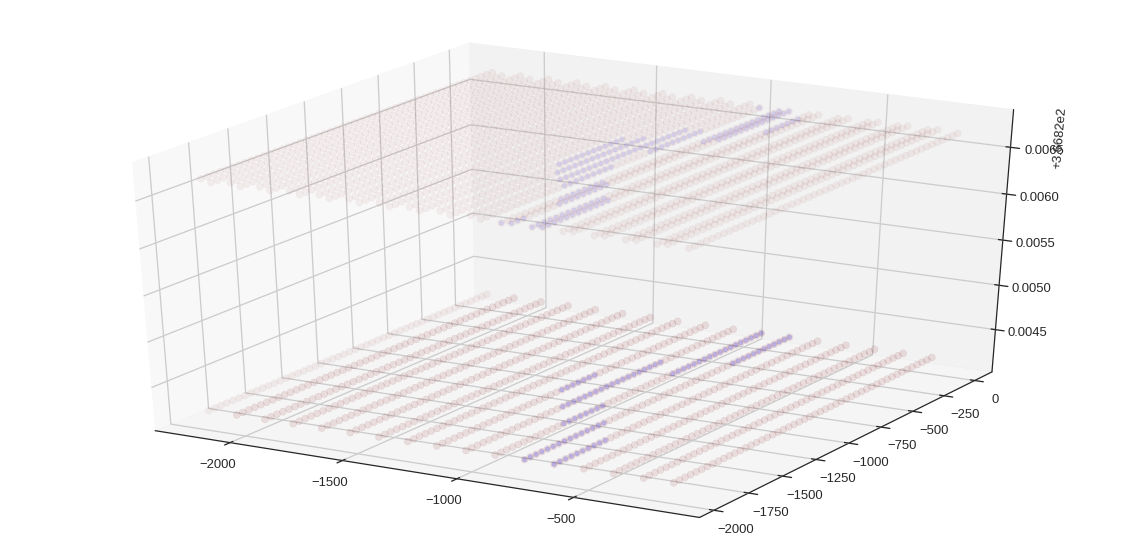

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(new[:, 0], new[:, 1], new[:, 2], color='b', alpha=0.1)
ax.scatter(fault_rot[:, 0], fault_rot[:, 1], fault_rot[:, 2], alpha=.05, s=50, color='maroon')
#ax.scatter(v_f[:, 0], v_f[:, 1], v_f[:, 2], color='r', alpha=0.1)
#ax.scatter(intersect[:, 0], intersect[:, 1], intersect[:, 2], color='maroon', alpha=0.7)

In [31]:
new_frame = np.zeros_like(fault_rot)
#rot_bool= np.zeros_like(fault_rot)
new_frame[:331,:]=new
rot_bool = np.logical_and(fault_rot,new_frame)

In [32]:
rot_bool.shape

(3300, 3)

In [33]:
np.min(new[:,0])

-1176.3672912070692

In [34]:
len_sorted = new[new[:,1].argsort()]
#upper_b = len_sorted[np.amax(len_sorted[:,1])]

In [35]:
hold1 = []
minima = np.array([0,0])
maxima = np.array([0,0])
uniques = np.unique(new[:,1])
counter = 0

for i in np.arange(0,len(len_sorted)):
    if len_sorted[i,1] == uniques[counter]:
        hold1 = np.append(hold1, [len_sorted[i,0]])
    else:
        if len(hold1) > 0:
            minima = np.vstack((minima, np.array([np.min(hold1), len_sorted[i-1,1]])))
            maxima = np.vstack((maxima, np.array([np.max(hold1), len_sorted[i-1,1]])))
            print(uniques[counter],hold1,minima)
            hold1 = np.array([])
        counter += 1
minima = np.delete(minima, 0,0)
maxima = np.delete(maxima, 0,0)

-1960.0 [-839.05850246 -881.22220057 -712.56739605 -754.73109417 -796.89397199
 -796.89397199 -670.40286558 -670.40286558] [[    0.             0.        ]
 [ -881.22220057 -1960.        ]]
-1920.0 [-712.56739605 -796.89397199 -796.89397199 -670.40286558 -670.40286558
 -754.73109417] [[    0.             0.        ]
 [ -881.22220057 -1960.        ]
 [ -796.89397199 -1920.        ]]
-1880.0 [-839.05850246 -670.40286558 -712.56739605 -754.73109417 -796.89397199
 -796.89397199] [[    0.             0.        ]
 [ -881.22220057 -1960.        ]
 [ -796.89397199 -1920.        ]
 [ -839.05850246 -1880.        ]]
-1840.0 [-796.89397199 -754.73109417 -796.89397199 -670.40286558 -670.40286558] [[    0.             0.        ]
 [ -881.22220057 -1960.        ]
 [ -796.89397199 -1920.        ]
 [ -839.05850246 -1880.        ]
 [ -796.89397199 -1840.        ]]
-1800.0 [-670.40286558 -796.89397199 -670.40286558 -796.89397199 -754.73109417] [[    0.             0.        ]
 [ -881.22220057 -1960.     

-1120.0 [-1007.71331904 -1049.8761848  -1049.8761848  -1134.20442545 -1092.04071527] [[    0.             0.        ]
 [ -881.22220057 -1960.        ]
 [ -796.89397199 -1920.        ]
 [ -839.05850246 -1880.        ]
 [ -796.89397199 -1840.        ]
 [ -796.89397199 -1800.        ]
 [ -796.89397199 -1760.        ]
 [ -796.89397199 -1720.        ]
 [ -796.89397199 -1680.        ]
 [ -839.05850246 -1640.        ]
 [ -839.05850246 -1600.        ]
 [ -839.05850246 -1560.        ]
 [ -881.22220057 -1520.        ]
 [ -923.38507839 -1480.        ]
 [ -923.38507839 -1440.        ]
 [ -965.54960886 -1400.        ]
 [ -965.54960886 -1360.        ]
 [ -965.54960886 -1320.        ]
 [-1049.8761848  -1280.        ]
 [-1092.04071527 -1240.        ]
 [-1092.04071527 -1200.        ]
 [-1134.20442545 -1160.        ]
 [-1134.20442545 -1120.        ]]
-1080.0 [-1176.36729121  -965.54960886 -1134.20442545 -1092.04071527 -1049.8761848
 -1049.8761848  -1007.71331904] [[    0.             0.        ]
 [ -881

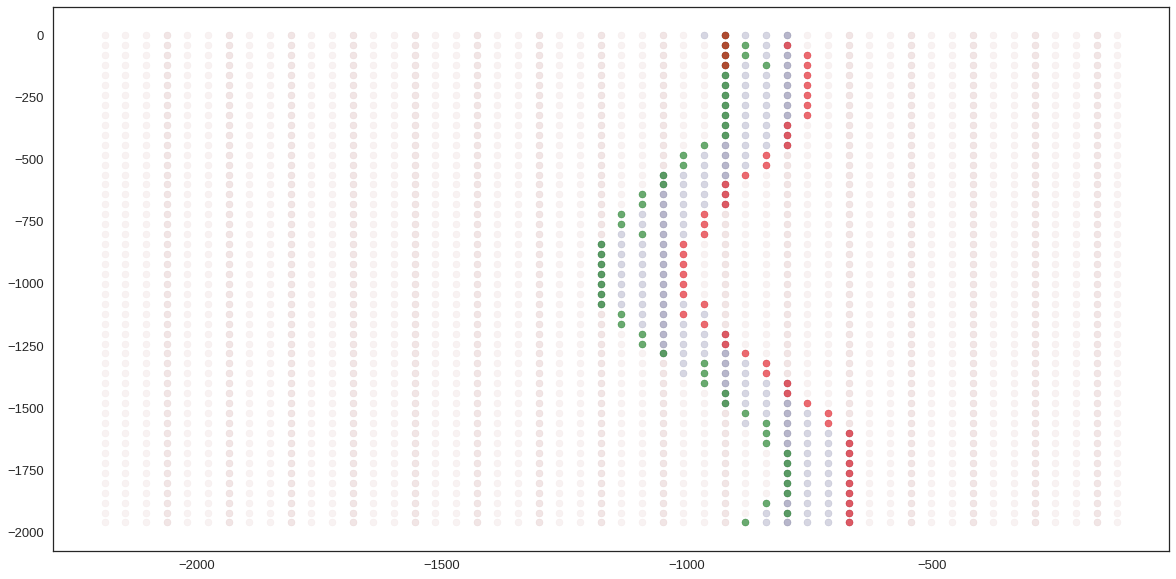

In [36]:
%matplotlib inline
figsize(20,10)
plt.scatter(new[:, 0], new[:, 1], alpha=.2, s=50)
plt.scatter(fault_rot[:, 0], fault_rot[:, 1], alpha=.05, s=50, color='maroon')
plt.scatter(minima[:, 0], minima[:, 1], alpha=.5, s=50, color='g')
plt.scatter(maxima[:, 0], minima[:, 1], alpha=.5, s=50, color='r')

In [37]:
fz_min = np.min(fault_rot[:,1])
cond1 = fault_rot[:,1] == fz_min
d1 = np.abs(np.max(fault_rot[cond1][:,0])-np.min(fault_rot[cond1][:,0]))
d2 = np.abs(np.max(fault_rot[cond1][:,2])-np.min(fault_rot[cond1][:,2]))
d3 = np.sqrt(d1**2+d2**2) #Satz des Pythagoras, I should be able to attain this fault length d3 before!
print(d1,d2,d3)
fault_extent = np.arange(0,d3,d3/geo_data.resolution[1])
fault_extent # goind too deep, there has to be an easier way!

2066.02058033 0.00251435949855 2066.02058033


array([    0.        ,    41.32041161,    82.64082321,   123.96123482,
         165.28164643,   206.60205803,   247.92246964,   289.24288125,
         330.56329285,   371.88370446,   413.20411607,   454.52452767,
         495.84493928,   537.16535089,   578.48576249,   619.8061741 ,
         661.12658571,   702.44699731,   743.76740892,   785.08782053,
         826.40823213,   867.72864374,   909.04905535,   950.36946695,
         991.68987856,  1033.01029017,  1074.33070177,  1115.65111338,
        1156.97152499,  1198.29193659,  1239.6123482 ,  1280.93275981,
        1322.25317141,  1363.57358302,  1404.89399462,  1446.21440623,
        1487.53481784,  1528.85522944,  1570.17564105,  1611.49605266,
        1652.81646426,  1694.13687587,  1735.45728748,  1776.77769908,
        1818.09811069,  1859.4185223 ,  1900.7389339 ,  1942.05934551,
        1983.37975712,  2024.70016872])

In [38]:
geo_data.formations.head()

,value,formation_number
MainFault,1,1
SecRes_Top,2,2
Seal_Top,3,3
Res_Top,4,4
Base_Top,5,5


# Approach: Analysis over voxels

/home/bl9/gempy/gempy/gempy_front.py:954: FutureWarning: gempy plotting functionality will be moved in version 1.2, use gempy.plotting module instead
  "use gempy.plotting module instead", FutureWarning)


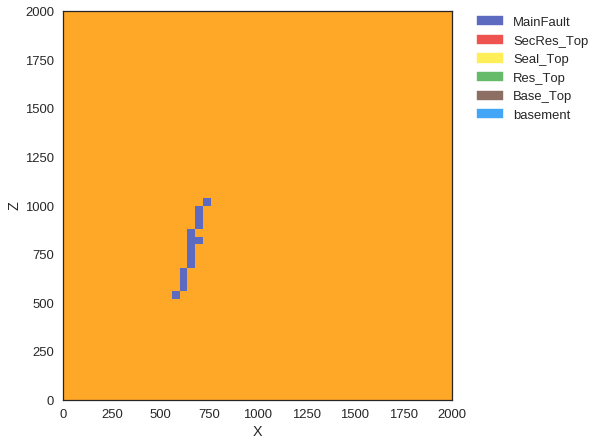

In [39]:
# will probably have to go through all fault formations to get each number and then
# apply this process for each single fault
fault_n = geo_data.formations.loc['MainFault','formation_number']

lith_block = lith_sol[0].reshape(geo_data.resolution[0],
                                 geo_data.resolution[1],geo_data.resolution[2])
fault_block = fault_sol[0].reshape(geo_data.resolution[0],
                                 geo_data.resolution[1],geo_data.resolution[2])

#fault_block = np.flip(fault_block, axis=0) # to test flipped fault
#fault_block = np.rot90(fault_block) # to test rotated fault

hw_cond = fault_block == fault_n
fw_cond = fault_block == (fault_n+1)
layer_cond = lith_block == res_n
hw_l_cond = layer_cond * hw_cond
fw_l_cond = layer_cond * fw_cond

# DIRECTION 1
roll_x11 = np.roll(hw_l_cond, 1, axis=0)
roll_x11[0,:,:] = False
roll_x21 = np.roll(fw_l_cond, -1, axis=0)
roll_x21[-1,:,:] = False
roll_y11 = np.roll(hw_l_cond, 1, axis=1)
roll_y11[:,0,:] = False
roll_y21 = np.roll(fw_l_cond, -1, axis=1)
roll_y21[:,-1,:] = False
roll_z11 = np.roll(hw_l_cond, -1, axis=2)
roll_z11[:,:,0] = False
roll_z21 = np.roll(fw_l_cond, 1, axis=2)
roll_z21[:,:,-1] = False

roll_x11[hw_cond] = False
roll_x21[fw_cond] = False
roll_y11[hw_cond] = False
roll_y21[fw_cond] = False
roll_z11[hw_cond] = False
roll_z21[fw_cond] = False

f_contact_x1 = np.logical_or(roll_x11, roll_x21)
f_contact_y1 = np.logical_or(roll_y11, roll_y21)
f_contact_z1 = np.logical_or(roll_z11, roll_z21)

f_contact1 = np.logical_or(f_contact_z1, np.logical_or(f_contact_x1, f_contact_y1))

# DIRECTION 2
roll_x12 = np.roll(fw_l_cond, 1, axis=0)
roll_x12[0,:,:] = False
roll_x22 = np.roll(hw_l_cond, -1, axis=0)
roll_x22[-1,:,:] = False
roll_y12 = np.roll(fw_l_cond, 1, axis=1)
roll_y12[:,0,:] = False
roll_y22 = np.roll(hw_l_cond, -1, axis=1)
roll_y22[:,-1,:] = False
roll_z12 = np.roll(fw_l_cond, -1, axis=2)
roll_z12[:,:,0] = False
roll_z22 = np.roll(hw_l_cond, 1, axis=2)
roll_z22[:,:,-1] = False

roll_x12[fw_cond] = False
roll_x22[hw_cond] = False
roll_y12[fw_cond] = False
roll_y22[hw_cond] = False
roll_z12[fw_cond] = False
roll_z22[hw_cond] = False

f_contact_x2 = np.logical_or(roll_x12, roll_x22)
f_contact_y2 = np.logical_or(roll_y12, roll_y22)
f_contact_z2 = np.logical_or(roll_z12, roll_z22)

f_contact2 = np.logical_or(f_contact_z2, np.logical_or(f_contact_x2, f_contact_y2))

# COMBINE BOTH DIRECTIONS
f_contact_all = np.logical_or(f_contact1, f_contact2)

gp.plot_section(geo_data, f_contact_all, 25, direction='y')

In [40]:
def get_fault_contact_old(geo_data, lith_sol, fault_sol, fault_n, fault_side='both'):
    lith_block = lith_sol[0].reshape(geo_data.resolution[0],
                                 geo_data.resolution[1],geo_data.resolution[2])
    fault_block = fault_sol[0].reshape(geo_data.resolution[0],
                                     geo_data.resolution[1],geo_data.resolution[2])
    
    #fault_block = np.flip(fault_block, axis=0) # to test flipped fault
    #fault_block = np.rot90(fault_block) # to test rotated fault
    
    hw_cond = fault_block == fault_n
    fw_cond = fault_block == (fault_n+1)
    layer_cond = lith_block == res_n
    hw_l_cond = layer_cond * hw_cond
    fw_l_cond = layer_cond * fw_cond
    
    # DIRECTION 1 - HW
    roll_x11 = np.roll(hw_l_cond, 1, axis=0)
    roll_x11[0,:,:] = False
    roll_y11 = np.roll(hw_l_cond, 1, axis=1)
    roll_y11[:,0,:] = False
    roll_z11 = np.roll(hw_l_cond, -1, axis=2)
    roll_z11[:,:,0] = False
    
    roll_x11[hw_cond] = False
    roll_y11[hw_cond] = False
    roll_z11[hw_cond] = False
    
    # DIRECTION 1 - FW
    roll_x21 = np.roll(fw_l_cond, -1, axis=0)
    roll_x21[-1,:,:] = False
    roll_y21 = np.roll(fw_l_cond, -1, axis=1)
    roll_y21[:,-1,:] = False
    roll_z21 = np.roll(fw_l_cond, 1, axis=2)
    roll_z21[:,:,-1] = False
    
    roll_x21[fw_cond] = False
    roll_y21[fw_cond] = False
    roll_z21[fw_cond] = False
    
    # DIRECTION 2 - HW
    roll_x22 = np.roll(hw_l_cond, -1, axis=0)
    roll_x22[-1,:,:] = False
    roll_y22 = np.roll(hw_l_cond, -1, axis=1)
    roll_y22[:,-1,:] = False
    roll_z22 = np.roll(hw_l_cond, 1, axis=2)
    roll_z22[:,:,-1] = False
    
    roll_x22[hw_cond] = False
    roll_y22[hw_cond] = False
    roll_z22[hw_cond] = False
    
    # DIRECTION 2 - FW
    roll_x12 = np.roll(fw_l_cond, 1, axis=0)
    roll_x12[0,:,:] = False
    roll_y12 = np.roll(fw_l_cond, 1, axis=1)
    roll_y12[:,0,:] = False
    roll_z12 = np.roll(fw_l_cond, -1, axis=2)
    roll_z12[:,:,0] = False
    
    roll_x12[fw_cond] = False
    roll_y12[fw_cond] = False
    roll_z12[fw_cond] = False
    
    if fault_side == 'both':
        # DIRECTION 1 - BOTH
        f_contact_x1 = np.logical_or(roll_x11, roll_x21)
        f_contact_y1 = np.logical_or(roll_y11, roll_y21)
        f_contact_z1 = np.logical_or(roll_z11, roll_z21)
        
        f_contact1 = np.logical_or(f_contact_z1, np.logical_or(f_contact_x1, f_contact_y1))
        
        # DIRECTION 2 - BOTH 
        f_contact_x2 = np.logical_or(roll_x12, roll_x22)
        f_contact_y2 = np.logical_or(roll_y12, roll_y22)
        f_contact_z2 = np.logical_or(roll_z12, roll_z22)
        
        f_contact2 = np.logical_or(f_contact_z2, np.logical_or(f_contact_x2, f_contact_y2))
        
        # COMBINE BOTH DIRECTIONS - BOTH SIDES
        f_contact_all = np.logical_or(f_contact1, f_contact2)
        return f_contact_all
    
    elif fault_side == 'hanging wall' or fault_side == 'hw':
        # COMBINE BOTH DIRECTIONS - HW
        f_contact_hw1 = np.logical_or(roll_z11, np.logical_or(roll_x11, roll_y11))    
        f_contact_hw2 = np.logical_or(roll_z22, np.logical_or(roll_x22, roll_y22))
        f_contact_hw = np.logical_or(f_contact_hw1, f_contact_hw2)
        return f_contact_hw
        
    elif fault_side == 'footwall' or fault_side == 'fw':
        # COMBINE BOTH DIRECTIONS - FW
        f_contact_fw1 = np.logical_or(roll_z21, np.logical_or(roll_x21, roll_y21))
        f_contact_fw2 = np.logical_or(roll_z12, np.logical_or(roll_x12, roll_y12))    
        f_contact_fw = np.logical_or(f_contact_fw1, f_contact_fw2)
        return f_contact_fw
    else:
        print('fault side has do be chosen as both, footwall or hanging wall.')
        return np.nan
    
def get_fault_juxtapos_old(geo_data, lith_sol, fault_sol, fault_n):
    fwc = get_fault_contact(geo_data, lith_sol, fault_sol, fault_n, fault_side='fw')
    hwc = get_fault_contact(geo_data, lith_sol, fault_sol, fault_n, fault_side='hw')
    juxtapos_voxels = np.logical_and(hwc, fwc)
    return juxtapos_voxels

In [41]:
fwc = get_fault_contact(geo_data, lith_sol, fault_sol, fault_n=1, fault_side='fw')
hwc = get_fault_contact(geo_data, lith_sol, fault_sol, fault_n=1, fault_side='hw')
contact = get_fault_contact(geo_data, lith_sol, fault_sol, fault_n=1, fault_side='both')
#overlap = np.roll(fwc, -1, axis=0) + np.roll(hwc, 1, axis=0)
overlap = fwc.astype(int) + hwc.astype(int)
juxtapos = get_fault_juxtapos(geo_data, lith_sol, fault_sol, fault_n=1)
#gp.plot_section(geo_data, layer_cond, 25, direction='y')
gp.plot_section(geo_data, overlap, 25, direction='y')

NameError: name 'get_fault_contact' is not defined

In [ ]:
vox_size_x = np.abs(geo_data.extent[1] - geo_data.extent[0]) / geo_data.resolution[0]
vox_size_y = np.abs(geo_data.extent[3] - geo_data.extent[2]) / geo_data.resolution[1]
vox_size_z = np.abs(geo_data.extent[5] - geo_data.extent[4]) / geo_data.resolution[2]
vox_size_diag = np.sqrt(vox_size_x ** 2 + vox_size_y ** 2 + vox_size_z ** 2)

contact_up = get_lith_fault_intersect(v_f,v_l)[0]
contact_low = get_lith_fault_intersect(v_f,v_l2)[0]
#contact = np.vstack((contact_up, contact_low))
contact = v_f
#contact = contact_low
hwc = get_fault_contact(geo_data, lith_sol, fault_sol, fault_n=1, fault_side='hw')
fwc = get_fault_contact(geo_data, lith_sol, fault_sol, fault_n=1, fault_side='fw')
jxp = get_fault_juxtapos(geo_data, lith_sol, fault_sol, fault_n=1)

if np.any(hwc):

    hwc_coord0 = np.argwhere(hwc == True)

    hwc_coord = hwc_coord0
    hwc_coord[:, 0] = (hwc_coord0[:, 0] * vox_size_x) + geo_data.extent[0]  #+ vox_size_x
    hwc_coord[:, 1] = (hwc_coord0[:, 1] * vox_size_y) + geo_data.extent[2]  #+ vox_size_y
    hwc_coord[:, 2] = (hwc_coord0[:, 2] * vox_size_z) + geo_data.extent[4]  #+ vox_size_z
    dist_hwc = distance.cdist(contact, hwc_coord, 'euclidean')

    min_dist_hwc = np.min(dist_hwc, axis=1)
    cut_bool_hwc = min_dist_hwc < (vox_size_diag / 2)
    contact_hwc_all = contact[cut_bool_hwc]
    
if np.any(fwc):

    fwc_coord0 = np.argwhere(fwc == True)

    fwc_coord = fwc_coord0
    fwc_coord[:, 0] = (fwc_coord0[:, 0] * vox_size_x) + geo_data.extent[0] #- vox_size_x
    fwc_coord[:, 1] = (fwc_coord0[:, 1] * vox_size_y) + geo_data.extent[2] #- vox_size_y
    fwc_coord[:, 2] = (fwc_coord0[:, 2] * vox_size_z) + geo_data.extent[4] #+ vox_size_z/2

    dist_fwc = distance.cdist(contact, fwc_coord, 'euclidean')

    min_dist_fwc = np.min(dist_fwc, axis=1)
    cut_bool_fwc = min_dist_fwc < (vox_size_diag / 2)
    contact_fwc_all = contact[cut_bool_fwc]
    
    # voxel correction:
    # + for HWC as voxels should be always "right" of the fault and the opposite for FWC,
    # but I am not 100 % shure if this is correct,
    # other option, add half a voxel to all for centralized spread
    # (else it is "left-shifted", I think)
if np.any(jxp):

    jxp_coord0 = np.argwhere(jxp == True)

    jxp_coord = jxp_coord0
    jxp_coord[:, 0] = (jxp_coord0[:, 0] * vox_size_x) + geo_data.extent[0] #+ vox_size_x/2
    jxp_coord[:, 1] = (jxp_coord0[:, 1] * vox_size_y) + geo_data.extent[2] #+ vox_size_y/2
    jxp_coord[:, 2] = (jxp_coord0[:, 2] * vox_size_z) + geo_data.extent[4] #+ vox_size_z/2
    
    # no voxel correction for juxtapos, as they are created from "overlap"
    # however, need to rethink if this overlap is really the correct juxtaposition,
    # as z-directed rolling of voxels might create
    # extra voxels...
    
    dist_jxp = distance.cdist(contact, jxp_coord, 'euclidean')

    min_dist_jxp = np.min(dist_jxp, axis=1)
    cut_bool_jxp = min_dist_jxp < (vox_size_diag / 2)
    contact_jxp_all = contact[cut_bool_jxp]

In [ ]:
print(np.max(contact_up[:,2]), np.max(contact_fwc_all[:,2]))
print(np.max(contact_low[:,2]), np.max(contact_hwc_all[:,2]))

### --> INACCURACY PROBLEM!?

In [ ]:
%matplotlib inline
figsize(20,20)

intersect_upper = get_lith_fault_intersect(v_f,v_l)[0]
intersect_lower = get_lith_fault_intersect(v_f,v_l2)[0]

#intersect_minima_all, intersect_maxima_all, intersect_saddles_all \
#        = sp.get_surface_extrema(geo_data, v_l, GX, GY)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(v_l[:, 0], v_l[:, 1], v_l[:, 2], color='k', alpha=0.05)
ax.scatter(v_f[:, 0], v_f[:, 1], v_f[:, 2], color='r', alpha=0.1)
ax.scatter(contact_hwc_all[:, 0], contact_hwc_all[:, 1], contact_hwc_all[:, 2], color='green', alpha=0.5)
ax.scatter(contact_fwc_all[:, 0], contact_fwc_all[:, 1], contact_fwc_all[:, 2], color='blue', alpha=0.5)
ax.scatter(contact_jxp_all[:, 0], contact_jxp_all[:, 1], contact_jxp_all[:, 2], color='maroon', alpha=0.8)
#ax.scatter(intersect[:, 0], intersect[:, 1], intersect[:, 2], color='maroon', alpha=0.7)

#if len(intersect_minima_all) > 0:
#    ax.scatter(intersect_minima_all[:, 0], intersect_minima_all[:, 1], intersect_minima_all[:, 2], \
#               color='blue',s=200, marker='o')
#if len(intersect_maxima_all) > 0:
#    ax.scatter(intersect_maxima_all[:,0],intersect_maxima_all[:,1],intersect_maxima_all[:,2],\
#               color='r', s=200, marker='o')
#if len(intersect_saddles_all) > 0:
#    ax.scatter(intersect_saddles_all[:, 0], intersect_saddles_all[:, 1], intersect_saddles_all[:, 2], \
#               color='violet',s=200, marker='o')

ax.set_xlim(geo_data.extent[0], geo_data.extent[1])
ax.set_ylim(geo_data.extent[2], geo_data.extent[3])
ax.set_zlim(geo_data.extent[4], geo_data.extent[5])
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Depth [m]')
plt.show()

In [ ]:
def get_fault_contact_old2(geo_data, lith_sol, fault_sol, fault_n, fault_side='both'):
    lith_block = lith_sol[0].reshape(geo_data.resolution[0],
                                 geo_data.resolution[1],geo_data.resolution[2])
    fault_block = fault_sol[0].reshape(geo_data.resolution[0],
                                     geo_data.resolution[1],geo_data.resolution[2])
    
    #fault_block = np.flip(fault_block, axis=0) # to test flipped fault
    #fault_block = np.rot90(fault_block) # to test rotated fault
    
    hw_cond = fault_block == fault_n
    fw_cond = fault_block == (fault_n+1)
    layer_cond = lith_block == res_n
    hw_l_cond = layer_cond * hw_cond
    fw_l_cond = layer_cond * fw_cond
    
    # DIRECTION 1 - HW
    roll_x11 = np.roll(hw_l_cond, 1, axis=0)
    roll_x11[0,:,:] = False
    roll_y11 = np.roll(hw_l_cond, 1, axis=1)
    roll_y11[:,0,:] = False
    roll_z11 = np.roll(hw_l_cond, -1, axis=2)
    roll_z11[:,:,0] = False
    
    roll_x11[hw_cond] = False
    roll_y11[hw_cond] = False
    roll_z11[hw_cond] = False
    
    # DIRECTION 1 - FW
    roll_x21 = np.roll(fw_l_cond, -1, axis=0)
    roll_x21[-1,:,:] = False
    roll_y21 = np.roll(fw_l_cond, -1, axis=1)
    roll_y21[:,-1,:] = False
    roll_z21 = np.roll(fw_l_cond, 1, axis=2)
    roll_z21[:,:,-1] = False
    
    roll_x21[fw_cond] = False
    roll_y21[fw_cond] = False
    roll_z21[fw_cond] = False
    
    # DIRECTION 2 - HW
    roll_x22 = np.roll(hw_l_cond, -1, axis=0)
    roll_x22[-1,:,:] = False
    roll_y22 = np.roll(hw_l_cond, -1, axis=1)
    roll_y22[:,-1,:] = False
    roll_z22 = np.roll(hw_l_cond, 1, axis=2)
    roll_z22[:,:,-1] = False
    
    roll_x22[hw_cond] = False
    roll_y22[hw_cond] = False
    roll_z22[hw_cond] = False
    
    # DIRECTION 2 - FW
    roll_x12 = np.roll(fw_l_cond, 1, axis=0)
    roll_x12[0,:,:] = False
    roll_y12 = np.roll(fw_l_cond, 1, axis=1)
    roll_y12[:,0,:] = False
    roll_z12 = np.roll(fw_l_cond, -1, axis=2)
    roll_z12[:,:,0] = False
    
    roll_x12[fw_cond] = False
    roll_y12[fw_cond] = False
    roll_z12[fw_cond] = False
    
    if fault_side == 'both':
        # DIRECTION 1 - BOTH
        f_contact_x1 = np.logical_or(roll_x11, roll_x21)
        f_contact_y1 = np.logical_or(roll_y11, roll_y21)
        f_contact_z1 = np.logical_or(roll_z11, roll_z21)
        
        f_contact1 = np.logical_or(f_contact_z1, np.logical_or(f_contact_x1, f_contact_y1))
        
        # DIRECTION 2 - BOTH 
        f_contact_x2 = np.logical_or(roll_x12, roll_x22)
        f_contact_y2 = np.logical_or(roll_y12, roll_y22)
        f_contact_z2 = np.logical_or(roll_z12, roll_z22)
        
        f_contact2 = np.logical_or(f_contact_z2, np.logical_or(f_contact_x2, f_contact_y2))
        
        # COMBINE BOTH DIRECTIONS - BOTH SIDES
        f_contact_all = np.logical_or(f_contact1, f_contact2)
        return f_contact_all
    
    elif fault_side == 'hanging wall' or fault_side == 'hw':
        # COMBINE BOTH DIRECTIONS - HW
        f_contact_hw1 = np.logical_or(roll_z11, np.logical_or(roll_x11, roll_y11))    
        f_contact_hw2 = np.logical_or(roll_z22, np.logical_or(roll_x22, roll_y22))
        f_contact_hw = np.logical_or(f_contact_hw1, f_contact_hw2)
        return f_contact_hw
        
    elif fault_side == 'footwall' or fault_side == 'fw':
        # COMBINE BOTH DIRECTIONS - FW
        f_contact_fw1 = np.logical_or(roll_z21, np.logical_or(roll_x21, roll_y21))
        f_contact_fw2 = np.logical_or(roll_z12, np.logical_or(roll_x12, roll_y12))    
        f_contact_fw = np.logical_or(f_contact_fw1, f_contact_fw2)
        return f_contact_fw
    else:
        print('fault side has do be chosen as both, footwall or hanging wall.')
        return np.nan
    
#def get_fault_juxtapos(geo_data, lith_sol, fault_sol, fault_n):
#    fwc = get_fault_contact(geo_data, lith_sol, fault_sol, fault_n, fault_side='fw')
#    hwc = get_fault_contact(geo_data, lith_sol, fault_sol, fault_n, fault_side='hw')
#    juxtapos_voxels = np.logical_and(hwc, fwc)
#    return juxtapos_voxels

In [42]:
def get_fault_mask(geo_data, fault_sol, fault_n, fault_side='both'):
    fault_block = fault_sol[0].astype(int).reshape(geo_data.resolution[0],
                                     geo_data.resolution[1],geo_data.resolution[2])
    
    # boolean conditions for hanging and footwall 
    hw_cond = fault_block == fault_n
    fw_cond = fault_block == (fault_n+1)
    hw_cond = np.pad(hw_cond, (1), 'edge')
    fw_cond = np.pad(fw_cond, (1), 'edge')
    
    ### ROLLING
    # FW MASK 1
    roll_x11 = np.roll(hw_cond, 1, axis=0)
    roll_y11 = np.roll(hw_cond, 1, axis=1)
    roll_z11 = np.roll(hw_cond, -1, axis=2)
    
    roll_x11[hw_cond] = False
    roll_y11[hw_cond] = False
    roll_z11[hw_cond] = False
    
    # HW MASK 1
    roll_x21 = np.copy(hw_cond)
    roll_y21 = np.copy(hw_cond)
    roll_z21 = np.copy(hw_cond)
    
    roll_x21_cut = np.roll(hw_cond, -1, axis=0)
    roll_y21_cut = np.roll(hw_cond, -1, axis=1)
    roll_z21_cut = np.roll(hw_cond, 1, axis=2)
    
    roll_x21[roll_x21_cut] = False
    roll_y21[roll_y21_cut] = False
    roll_z21[roll_z21_cut] = False
    
    # FW MASK 2
    roll_x22 = np.copy(fw_cond)
    roll_y22 = np.copy(fw_cond)
    roll_z22 = np.copy(fw_cond)
    
    roll_x22_cut = np.roll(fw_cond, -1, axis=0)
    roll_y22_cut = np.roll(fw_cond, -1, axis=1)
    roll_z22_cut = np.roll(fw_cond, 1, axis=2)
    
    roll_x22[roll_x22_cut] = False
    roll_y22[roll_y22_cut] = False
    roll_z22[roll_z22_cut] = False
    
    # HW MASK 2
    roll_x12 = np.roll(fw_cond, 1, axis=0)
    roll_y12 = np.roll(fw_cond, 1, axis=1)
    roll_z12 = np.roll(fw_cond, -1, axis=2)
    
    roll_x12[fw_cond] = False
    roll_y12[fw_cond] = False
    roll_z12[fw_cond] = False
    
    # COMBINE BOTH DIRECTIONS - HW
    f_mask_hw1 = np.logical_or(roll_z21, np.logical_or(roll_x21, roll_y21))
    f_mask_hw2 = np.logical_or(roll_z12, np.logical_or(roll_x12, roll_y12))    
    f_mask_hw = np.logical_or(f_mask_hw1, f_mask_hw2)[1:-1,1:-1,1:-1] 
    
    # COMBINE BOTH DIRECTIONS - FW
    f_mask_fw1 = np.logical_or(roll_z11, np.logical_or(roll_x11, roll_y11))    
    f_mask_fw2 = np.logical_or(roll_z22, np.logical_or(roll_x22, roll_y22))
    f_mask_fw = np.logical_or(f_mask_fw1, f_mask_fw2)[1:-1,1:-1,1:-1] 
    
    # COMBINE BOTH SIDES
    f_mask_both = np.logical_or(f_mask_hw, f_mask_fw)
    
    if fault_side == 'both':       
        return f_mask_both
    
    elif fault_side == 'hanging wall' or fault_side == 'hw':
        return f_mask_hw
        
    elif fault_side == 'footwall' or fault_side == 'fw':
        return f_mask_fw
    else:
        print('fault side has do be chosen as both, footwall or hanging wall.')
        return np.nan
    
#def get_fault_contact(geo_data, lith_sol, fault_sol, fault_n, fault_side='both'):
#    fwc = get_fault_contact(geo_data, lith_sol, fault_sol, fault_n, fault_side='fw')
#    hwc = get_fault_contact(geo_data, lith_sol, fault_sol, fault_n, fault_side='hw')

/home/bl9/gempy/gempy/gempy_front.py:954: FutureWarning: gempy plotting functionality will be moved in version 1.2, use gempy.plotting module instead
  "use gempy.plotting module instead", FutureWarning)


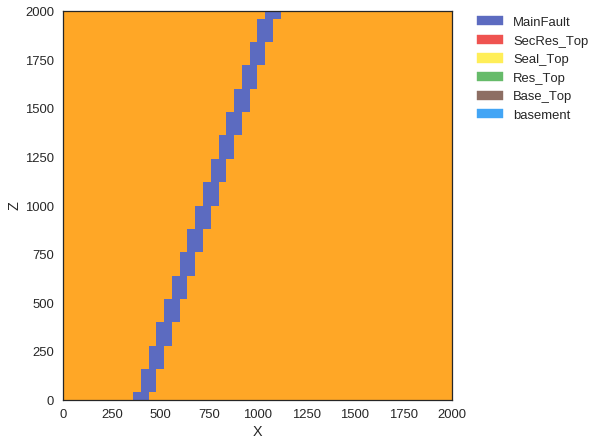

In [248]:
fwm = get_fault_mask(geo_data, fault_sol, fault_n=1, fault_side='fw')
hwm = get_fault_mask(geo_data, fault_sol, fault_n=1, fault_side='hw')
full_mask = get_fault_mask(geo_data, fault_sol, fault_n=1, fault_side='both')
overlap = fwm.astype(int) + hwm.astype(int)
#juxtapos = get_fault_juxtapos(geo_data, lith_sol, fault_sol, fault_n=1)
#gp.plot_section(geo_data, layer_cond, 25, direction='y')
gp.plot_section(geo_data, full_mask, 25, direction='y')

In [44]:
%%timeit
full_mask = get_fault_mask(geo_data, fault_sol, fault_n=1, fault_side='both')

4.61 ms ± 81.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:22: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
/home/bl9/gempy/gempy/gempy_front.py:954: FutureWarning: gempy plotting functionality will be moved in version 1.2, use gempy.plotting module instead
  "use gempy.plotting module instead", FutureWarning)


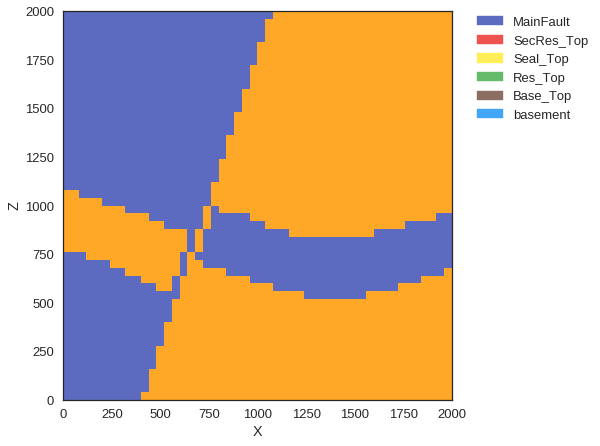

In [45]:
fault_n=1
lith_block=lith_sol[0].astype(int).reshape(geo_data.resolution[0],
                                     geo_data.resolution[1],geo_data.resolution[2])
fault_block = fault_sol[0].astype(int).reshape(geo_data.resolution[0],
                                     geo_data.resolution[1],geo_data.resolution[2])

hw_cond = fault_block == fault_n
fw_cond = fault_block == (fault_n+1)

layer_cond = lith_block == res_n
hw_l_cond = layer_cond * hwm
fw_l_cond = layer_cond * fwm
overlap_cond = np.logical_and(fw_l_cond, hw_l_cond) 
both_cond = layer_cond * full_mask

l_c = np.copy(layer_cond)
#l_c[~fw_cond]=False
l_c[hw_l_cond]=0
l_c[fw_l_cond]=0
l_c[overlap_cond]=0

gp.plot_section(geo_data, l_c-hw_cond, 25, direction='y')

/home/bl9/gempy/gempy/gempy_front.py:954: FutureWarning: gempy plotting functionality will be moved in version 1.2, use gempy.plotting module instead
  "use gempy.plotting module instead", FutureWarning)


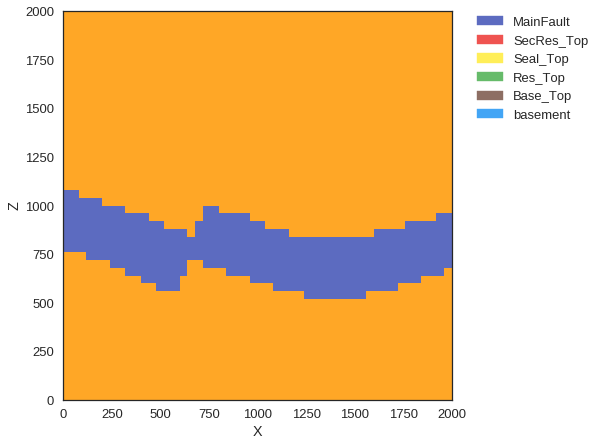

In [46]:
gp.plot_section(geo_data, layer_cond, 25, direction='y')

/home/bl9/gempy/gempy/gempy_front.py:954: FutureWarning: gempy plotting functionality will be moved in version 1.2, use gempy.plotting module instead
  "use gempy.plotting module instead", FutureWarning)


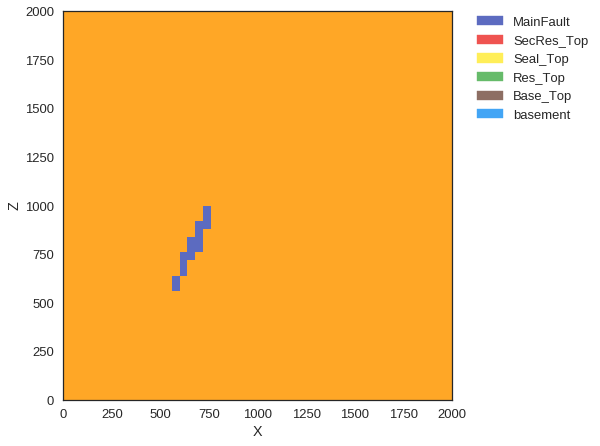

In [254]:
#hwl = layer_cond*hw_cond
#hwMM = hwl*hwm
#
#fwl = layer_cond*fw_cond
#fwMM = fwl*fwm
#
def get_vox_lf_contact(geo_data, lith_sol, fault_sol, \
                       lith_n, fault_n, fault_side='both'):
    fault_block = fault_sol[0].astype(int).reshape(geo_data.resolution[0],
                                     geo_data.resolution[1],geo_data.resolution[2])
    fault_mask = get_fault_mask(geo_data, fault_sol, fault_n, fault_side)
    lith_block = lith_sol[0].astype(int).reshape(geo_data.resolution[0],
                                     geo_data.resolution[1],geo_data.resolution[2])
    lith_cond = lith_block == lith_n
    if fault_side == 'hanging wall' or fault_side == 'hw':
        fs_cond = fault_block == fault_n
    elif fault_side == 'footwall' or fault_side == 'fw':
        fs_cond = fault_block == (fault_n+1)
    elif fault_side == 'both':
        fs_cond = np.ones_like(fault_block)        
    else:
        print('fault side has do be chosen as both, footwall or hanging wall.')
        return np.nan
    lith_cut = lith_cond * fs_cond
    vox_contact = fault_mask * lith_cut
    return vox_contact

hwMM = get_vox_lf_contact(geo_data, lith_sol, fault_sol, \
                          lith_n = res_n, fault_n=fault_n, fault_side='hw')   
    

gp.plot_section(geo_data, layer_cond, 25, direction='y')
gp.plot_section(geo_data, hwMM, 25, direction='y')

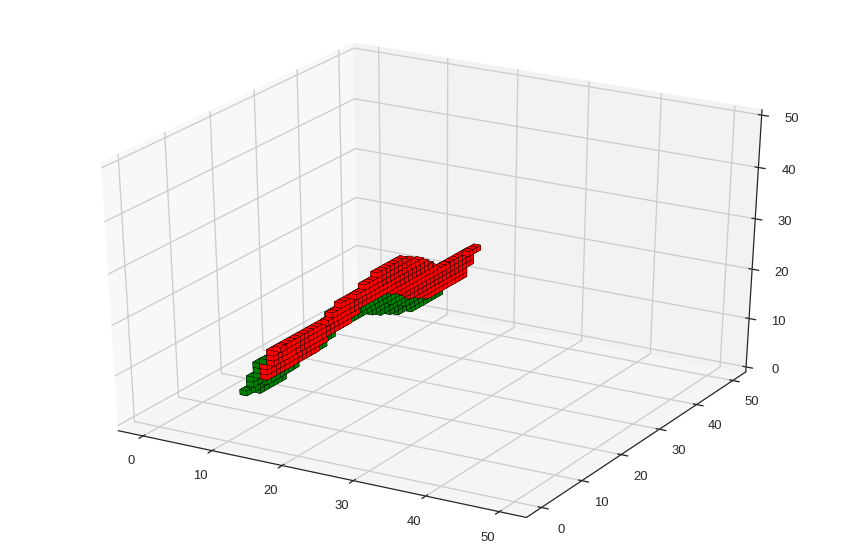

In [48]:
%matplotlib inline
fig = plt.figure(figsize(15,10))
ax = fig.gca(projection='3d')
ax.voxels(fwMM, facecolors='r', edgecolor='k')
ax.voxels(hwMM, facecolors='g', edgecolor='k')

plt.show()

In [49]:
fwm_proj_yz=np.zeros_like(fwMM)
fwm_proj_xz=np.zeros_like(fwMM)
fwm_pos = np.argwhere(fwMM==True)
fwm_pos_yz = np.copy(fwm_pos)
fwm_pos_xz = np.copy(fwm_pos)
fwm_pos_yz[:,0]= 0
fwm_pos_xz[:,1]= 49
fwm_proj_yz[fwm_pos_yz[:,0],fwm_pos_yz[:,1],fwm_pos_yz[:,2]] = True
fwm_proj_xz[fwm_pos_xz[:,0],fwm_pos_xz[:,1],fwm_pos_xz[:,2]] = True

In [50]:
hwm_proj_yz=np.zeros_like(hwMM)
hwm_proj_xz=np.zeros_like(hwMM)
hwm_pos = np.argwhere(hwMM==True)
hwm_pos_yz = np.copy(hwm_pos)
hwm_pos_xz = np.copy(hwm_pos)
hwm_pos_yz[:,0]= 0
hwm_pos_xz[:,1]= 49
hwm_proj_yz[hwm_pos_yz[:,0],hwm_pos_yz[:,1],hwm_pos_yz[:,2]] = True
hwm_proj_xz[hwm_pos_xz[:,0],hwm_pos_xz[:,1],hwm_pos_xz[:,2]] = True

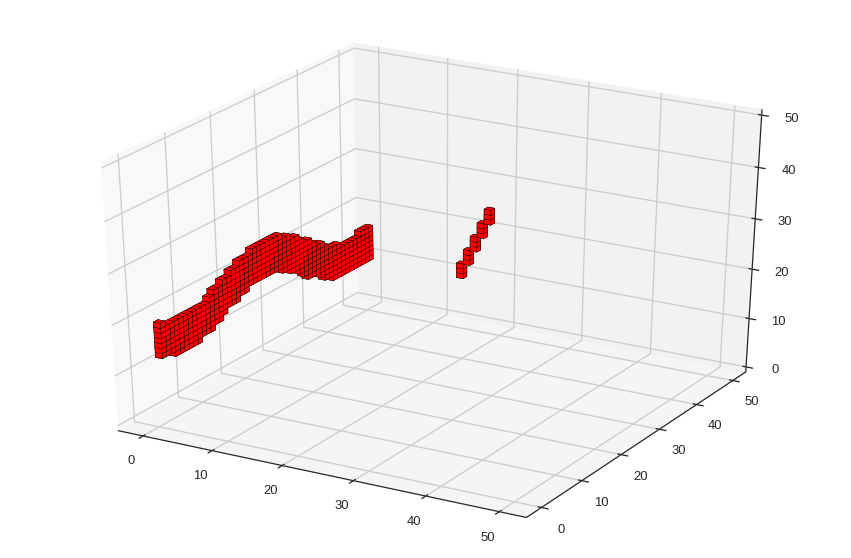

In [51]:
fig = plt.figure(figsize(15,10))
ax = fig.gca(projection='3d')
ax.voxels(fwm_proj_yz, facecolors='r', edgecolor='k')
ax.voxels(fwm_proj_xz, facecolors='r', edgecolor='k')
#ax.voxels(hwm_proj, facecolors='g', edgecolor='k')

plt.show()

In [52]:
fwm_yz_roll1 = np.roll(fwm_proj_yz,1,axis=2)
fwm_yz_roll1[:,:,0] = 0
fwm_yz_roll2 = np.roll(fwm_proj_yz,-1,axis=2)
fwm_yz_roll2[:,:,-1] = 0

fwm_maxline = fwm_proj_yz - fwm_yz_roll2
fwm_maxline[~fwm_proj_yz] = 0

fwm_minline = fwm_proj_yz - fwm_yz_roll1
fwm_minline[~fwm_proj_yz] = 0

/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:6: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:9: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  if __name__ == '__main__':


In [236]:
def project_voxels(voxel_array, projection='automatic'):
    if projection == 'automatic':
        d_x = (np.max(voxel_array[:,0])-np.min(voxel_array[:,0]))
        d_y = (np.max(voxel_array[:,1])-np.min(voxel_array[:,1]))
        if d_x > d_y: 
            projection = 'xz'
        else:
            projection = 'yz'
    if projection == 'yz':
        p = 0
    elif projection == 'xz':
        p = 1
    else:
        print('Projection plane should be yz, xz or automatic.')
        p=0        
    proj = np.zeros_like(voxel_array) 
    pos = np.argwhere(voxel_array==True)
    pos[:,p] = 0
    proj[pos[:,0],pos[:,1],pos[:,2]] = True
    return proj

def get_extrema_line_projected(projected_array, ext_type='max'):
    if ext_type == 'max':
        roll = np.roll(projected_array,-1,axis=2)
        roll[:,:,-1] = 0
        ext_line = np.bitwise_xor(projected_array,roll)
        ext_line[~projected_array] = 0
    elif ext_type == 'min':
        roll = np.roll(projected_array,1,axis=2)
        roll[:,:,0] = 0
        ext_line = np.bitwise_xor(projected_array,roll)
        ext_line[~projected_array] = 0
    else:
        print('ext_type must be either max or min.')
        ext_line=np.nan
    return ext_line   

def get_extrema_line_voxels(voxel_array, ext_type='max', projection='automatic', form='projected'):
    projected_array = project_voxels(voxel_array, projection)
    ext_line_p = get_extrema_line_projected(projected_array, ext_type)
    if form == 'projected':
        return ext_line_p 
    elif form == 'original':
        return ext_line_o
    #ext_line_r = np.zeros_like(voxel_array)
        #if projection == 'automatic':
    #    d_x = (np.max(projected_array[:,0])-np.min(projected_array[:,0]))
    #    d_y = (np.max(projected_array[:,1])-np.min(projected_array[:,1]))
    #    if d_x > d_y: 
    #        i = 0
    #    else:
    #        i = 1
    #elif projection == 'yz':
    #    i = 1
    #elif projection == 'xz':
    #    i = 0
    #rcond1 = voxel_array[:,2] == ext_line_p[:,2]
    #ext_line_r[rcond1] = 1
    ### need to find out how to come back to original form
    else:
        print('form needs to be projected or original.')
        
def get_juxtaposition(hw_array, fw_array):
    juxtapos = np.logical_and(hw_array, fw_array)
    return juxtapos

def plot_allan_diagram(hw_array, fw_array, projection='automatic'):
    if projection == 'automatic':
        d_x = (np.max(hw_array[:,0])-np.min(hw_array[:,0]))
        d_y = (np.max(hw_array[:,1])-np.min(hw_array[:,1]))
        if d_x > d_y: 
            projection = 'xz'
        else:
            projection = 'yz'
    fw_proj = project_voxels(fw_array, projection)
    fw_maxline = get_extrema_line_voxels(fw_array, ext_type='max', projection=projection)
    fw_minline = get_extrema_line_voxels(fw_array, ext_type='min', projection=projection)
    fw_between = np.bitwise_xor(fw_proj,np.logical_or(fw_maxline,fw_minline))

    hw_proj = project_voxels(hw_array, projection)
    hw_maxline = get_extrema_line_voxels(hw_array, ext_type='max', projection=projection)
    hw_minline = get_extrema_line_voxels(hw_array, ext_type='min', projection=projection)
    hw_between = np.bitwise_xor(hw_proj,np.logical_or(hw_maxline,hw_minline))

    juxtapos = np.logical_and(fw_proj, hw_proj)
    
    if projection == 'yz':
        diagram = np.zeros_like(hw_array[0,:,:].astype(int))
    
        diagram[fw_maxline[0,:,:]] = 1
        diagram[fw_minline[0,:,:]] = 1
        diagram[fw_between[0,:,:]] = 1
        
        diagram[hw_maxline[0,:,:]] = 2
        diagram[hw_minline[0,:,:]] = 2
        diagram[hw_between[0,:,:]] = 2
        
        diagram[juxtapos[0,:,:]]=3
    elif projection == 'xz':
        diagram = np.zeros_like(hw_array[:,0,:].astype(int))
    
        diagram[fw_maxline[:,0,:]] = 1
        diagram[fw_minline[:,0,:]] = 1
        diagram[fw_between[:,0,:]] = 1
        
        diagram[hw_maxline[:,0,:]] = 2
        diagram[hw_minline[:,0,:]] = 2
        diagram[hw_between[:,0,:]] = 2
        
        diagram[juxtapos[:,0,:]]=3
        
    else:
        return np.nan
        #RAISE ERROR
    plt.imshow(diagram.T, origin='bottom', cmap='viridis')
    return diagram
    
def plot_footwall_projection(fw_array, projection='automatic'):
    if projection == 'automatic':
        d_x = (np.max(fw_array[:,0])-np.min(fw_array[:,0]))
        d_y = (np.max(fw_array[:,1])-np.min(fw_array[:,1]))
        if d_x > d_y: 
            projection = 'xz'
        else:
            projection = 'yz'
    fw_proj = project_voxels(fw_array, projection)
    if projection  == 'yz':
        plt.imshow(fw_proj[0,:,:].T, origin='bottom', cmap='viridis')
    elif projection  == 'xz':
        plt.imshow(fw_proj[:,0,:].T, origin='bottom', cmap='viridis')
    else:
        print('Projection plane should be yz, xz or automatic.')
    
def plot_hanging_wall_projection(hw_array, projection='automatic'):
    if projection == 'automatic':
        d_x = (np.max(fw_array[:,0])-np.min(fw_array[:,0]))
        d_y = (np.max(fw_array[:,1])-np.min(fw_array[:,1]))
        if d_x > d_y: 
            projection = 'xz'
        else:
            projection = 'yz'
    hw_proj = project_voxels(fw_array, projection)
    if projection  == 'yz':
        plt.imshow(hw_proj[0,:,:].T, origin='bottom', cmap='viridis')
    elif projection  == 'xz':
        plt.imshow(hw_proj[:,0,:].T, origin='bottom', cmap='viridis')
    else:
        print('Projection plane should be yz, xz or automatic.')

In [237]:
interp_data.interpolator.tg.select_finite_faults()

/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: stack(*tensors) interface is deprecated, use stack(tensors, axis=0) instead.
  """Entry point for launching an IPython kernel.


Elemwise{lt,no_inplace}.0

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

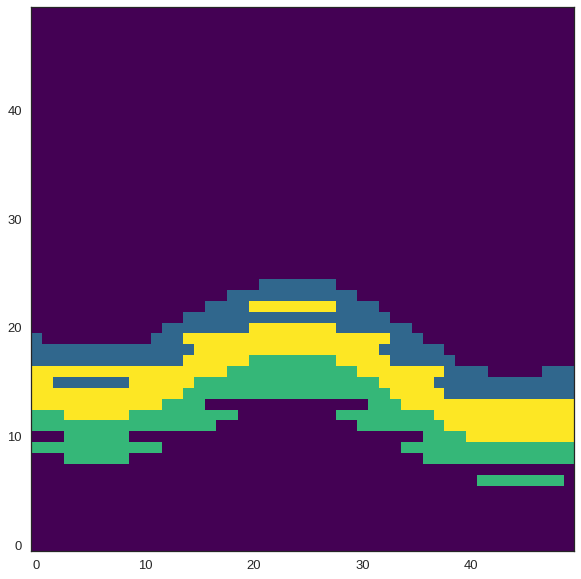

In [27]:
fa.plot_allan_diagram(geo_data, lith_sol, fault_sol, lith_n = res_n, fault_n = fault_n)

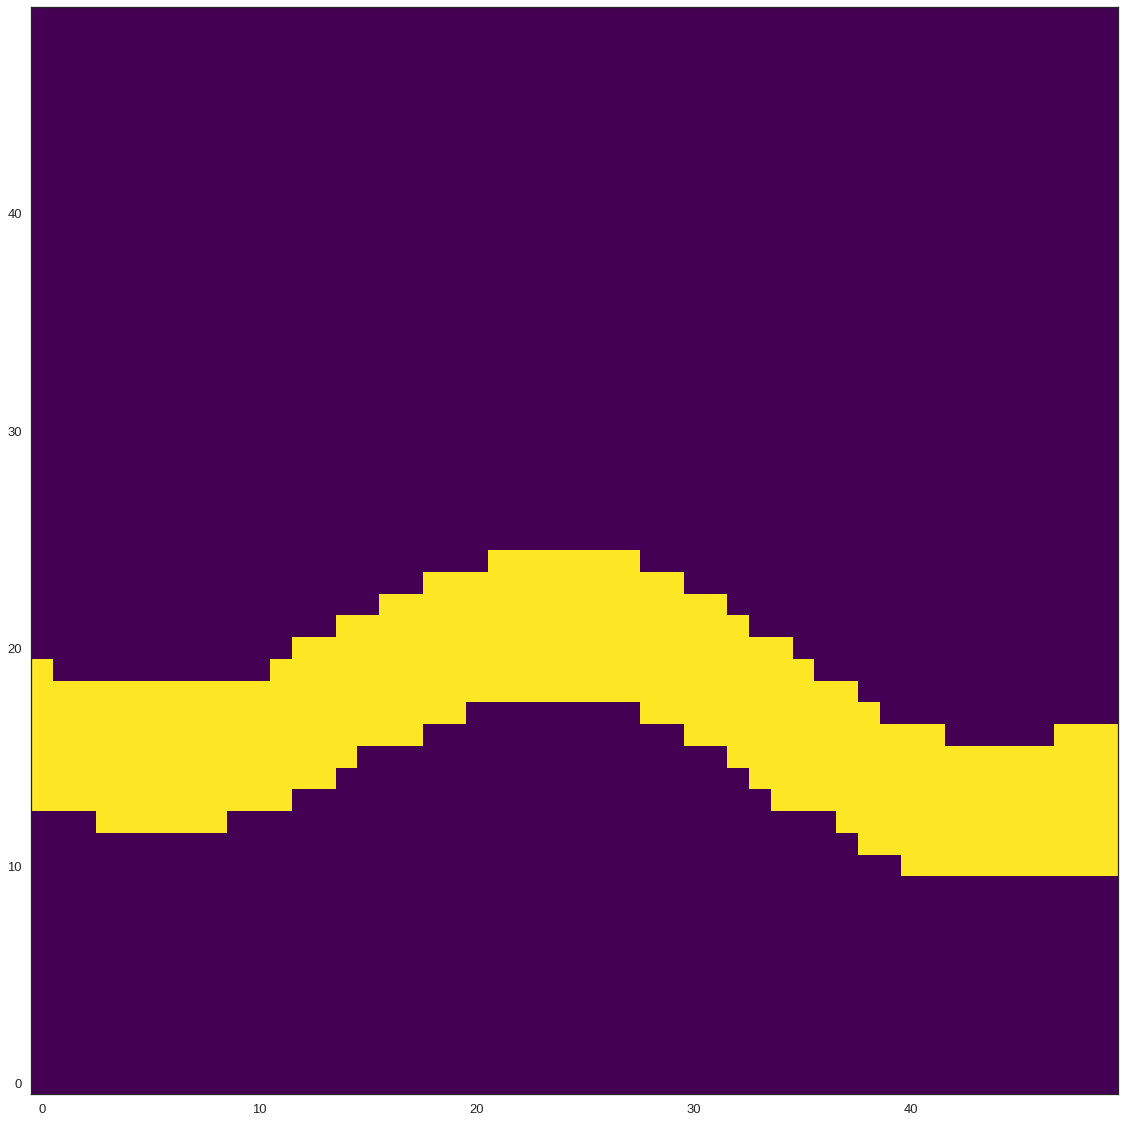

In [238]:
plot_footwall_projection(fwMM, projection='yz')

/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:69: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:70: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

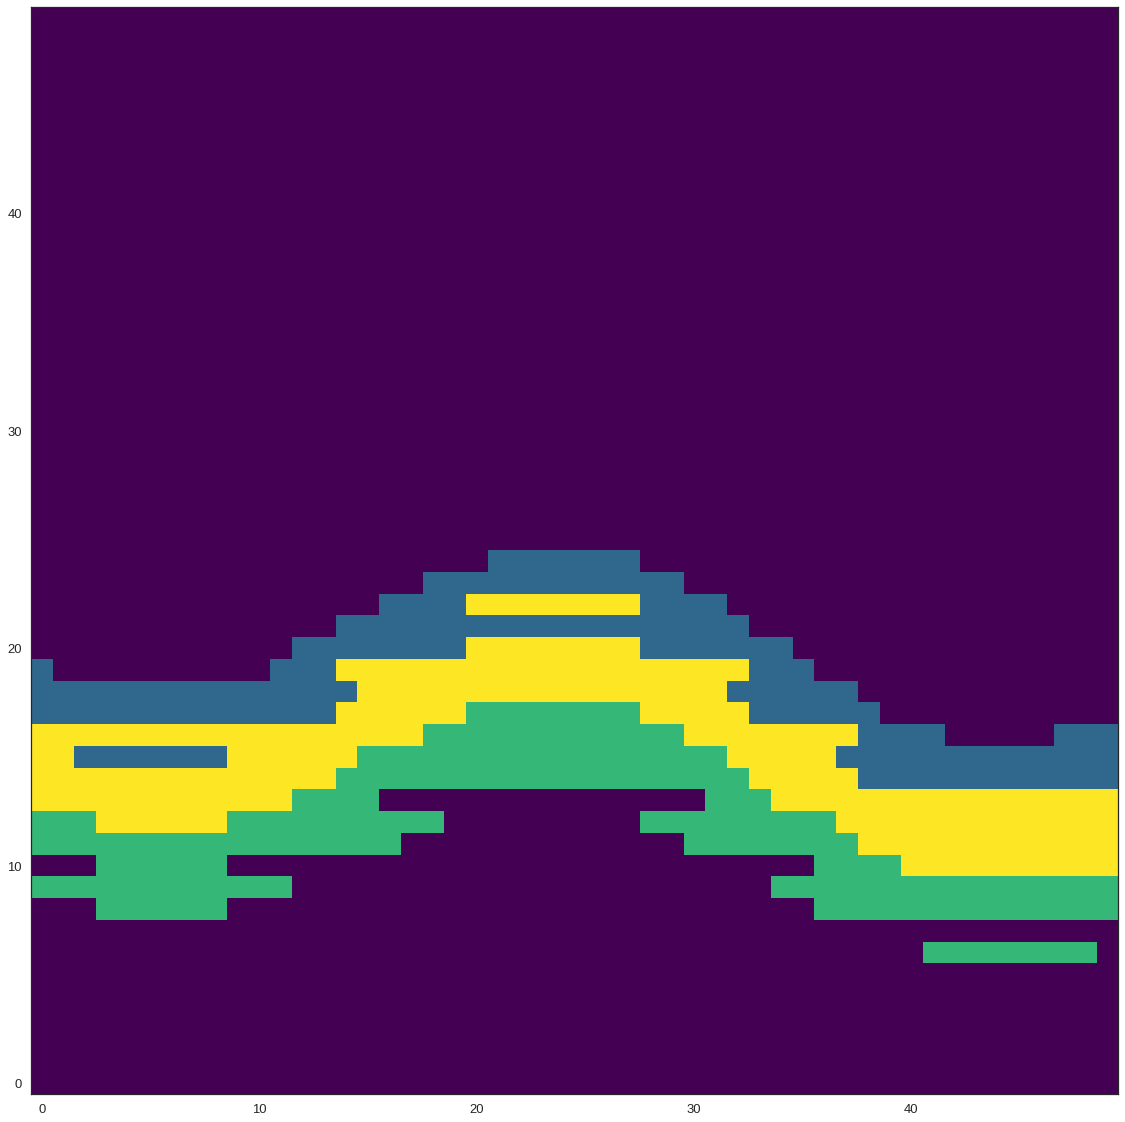

In [239]:
plot_allan_diagram(hwMM, fwMM, projection='automatic')

In [240]:
p_max = get_extrema_line_voxels(fwMM, ext_type='max', projection='yz')
p_min = get_extrema_line_voxels(fwMM, ext_type='min', projection='yz')
p_bet = np.bitwise_xor(fwm_proj_yz,(p_max+p_min))

p_max2 = get_extrema_line_voxels(hwMM, ext_type='max', projection='yz')
p_min2 = get_extrema_line_voxels(hwMM, ext_type='min', projection='yz')
p_bet2 = np.bitwise_xor(hwm_proj_yz,(p_max2+p_min2))

p_juxtapos = np.logical_and(fwm_proj_yz,hwm_proj_yz)

In [244]:
# get local extrema from extrema lines
import scipy.signal as sg
maxpos = np.argwhere(p_max==True)
possum = np.sum(maxpos, axis=0)
emptypos = np.argwhere(possum==0)
maxpos_reduced = np.delete(maxpos, emptypos, 1)
comp_order = np.int(np.round(((geo_data.resolution[0]+geo_data.resolution[1])/2)/2))
#sg.argrelextrema(maxpos_reduced[:,1], np.greater_equal, order=comp_order)
#finds extrema in general:
#sg.find_peaks_cwt(maxpos_reduced[:,1], widths=np.array([comp_order]))
faultmaxpos_upper = sg.find_peaks_cwt(maxpos_reduced[:,1], widths=np.array([comp_order*2]))
### NEED TO CHECK IF THIS IS A VIABLE FUNCTION, how to choose widths? changeable parameter?
# maybe widths should be something like the widths of fault sections relative to fault length
z_fmax0 = maxpos_reduced[faultmaxpos_upper,1]

# now look for z of lower
maxpos1 = np.argwhere(p_max2==True) # getting a shape too big for maxpos1, as HW side is bugged
maxpos1_reduced = np.delete(maxpos1, emptypos, 1)
## for now, clean up array with loop:
maxpos1_corrected = np.zeros_like(maxpos_reduced)
maxpos1_corrected[:,0] = np.arange(0,50,1)
for i in maxpos1_corrected[:,0]:
    filter_max = np.max(maxpos1_reduced[np.argwhere(maxpos1_reduced[:,0]==i),1])
    maxpos1_corrected[i,1] = filter_max

z_fmax1 = maxpos1_corrected[faultmaxpos_upper,1]

# fault throw at point of max point on footwall side
z_diff_maxp = np.abs(z_fmax0-z_fmax1)

# fault throw for each fault voxel element
z_diff_all = (maxpos_reduced[:,1]-maxpos1_corrected[:,1])

# several throw results
z_diff_mean = np.mean(z_diff_all)
z_diff_min = np.min(z_diff_all)
z_diff_max = np.max(z_diff_all)

def get_faultthrow_at(maxline_fw, maxline_hw, position=np.int(np.round(((geo_data.resolution[0]+geo_data.resolution[1])/2)/2))):
    maxpos_fw = np.argwhere(maxline_fw==True)
    possum_fw = np.sum(maxpos_fw, axis=0)
    emptypos_fw = np.argwhere(possum_fw==0)
    maxpos_fw_red = np.delete(maxpos_fw, emptypos_fw, 1)
    
    maxpos_hw = np.argwhere(maxline_hw==True) # getting a shape too big for maxpos1, as HW side is bugged
    maxpos_hw_red = np.delete(maxpos_hw, emptypos, 1)
    
    if len(maxpos_fw_red) != len(maxpos_hw_red):
        if len(maxpos_fw_red) > len(maxpos_hw_red):
            maxpos_corrected = np.zeros_like(maxpos_hw_red)
            maxpos_corrected[:,0] = np.arange(0,50,1)
            for i in maxpos_corrected[:,0]:
                filter_max = np.max(maxpos_fw_red[np.argwhere(maxpos_fw_red[:,0]==i),1])
                maxpos_corrected[i,1] = filter_max
                maxpos_fw_red = maxpos_corrected
        elif len(maxpos_hw_red) > len(maxpos_fw_red):
            maxpos_corrected = np.zeros_like(maxpos_fw_red)
            maxpos_corrected[:,0] = np.arange(0,50,1)
            for i in maxpos_corrected[:,0]:
                filter_max = np.max(maxpos_hw_red[np.argwhere(maxpos_hw_red[:,0]==i),1])
                maxpos_corrected[i,1] = filter_max
                maxpos_hw_red = maxpos_corrected
    if position == 'faultmax':            
        # finding max for FW maxline only. should I make this optional? So possible to choose HW as reference?
        comp_order = np.int(np.round(((geo_data.resolution[0]+geo_data.resolution[1])/2)/2))
        faultmaxpos_fw = sg.find_peaks_cwt(maxpos_fw_red[:,1], widths=np.array([comp_order*2]))
        
        z_fmaxp0 = maxpos_fw_red[faultmaxpos_fw,1]
        z_fmaxp1 = maxpos_hw_red[faultmaxpos_fw,1]
        z_diff = np.abs(z_fmax0-z_fmax1)
    else: 
        z_fwp = maxpos_fw_red[position,1]
        z_hwp = maxpos_hw_red[position,1]
        z_diff = np.abs(z_fwp-z_hwp)
    return z_diff

In [245]:
get_faultthrow_at(p_max,p_max2, 'faultmax')

array([2])

In [243]:
len(maxpos1_corrected)#.shape

50

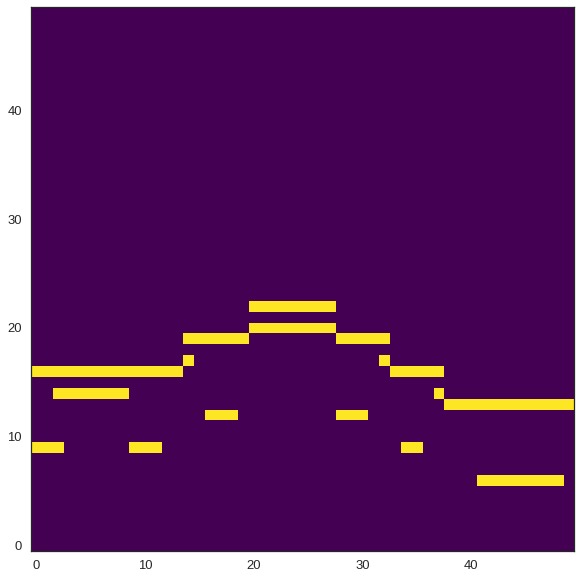

In [560]:
plt.imshow(p_max2[0,:,:].T, origin='bottom', cmap='viridis')

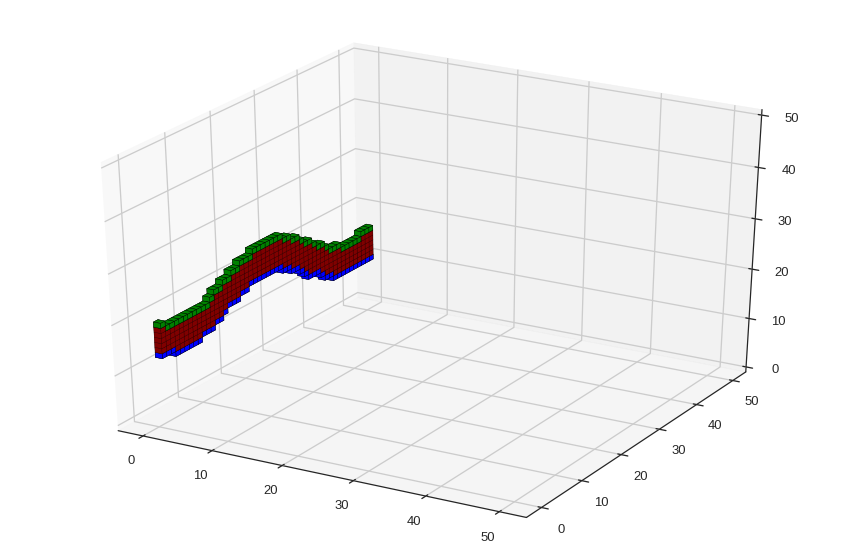

In [313]:
fig = plt.figure(figsize(15,10))
ax = fig.gca(projection='3d')
ax.voxels(p_bet, facecolors='maroon', edgecolor='k', alpha=0.5)
ax.voxels(p_max, facecolors='g', edgecolor='k')
ax.voxels(p_min, facecolors='b', edgecolor='k')
#ax.voxels(p_max, facecolors='purple', edgecolor='k')

plt.show()

In [341]:
diagram = np.zeros_like(p_max[0,:,:].astype(int))
diagram[p_bet[0,:,:]] = 1
diagram[p_max[0,:,:]] = 2
diagram[p_min[0,:,:]] = 3

In [359]:
diagram2 = np.zeros_like(p_max[0,:,:].astype(int))

diagram2[p_bet[0,:,:]] = 1
diagram2[p_max[0,:,:]] = 1
diagram2[p_min[0,:,:]] = 1

diagram2[p_bet2[0,:,:]] = 2
diagram2[p_max2[0,:,:]] = 2
diagram2[p_min2[0,:,:]] = 2

diagram2[p_juxtapos[0,:,:]]=3

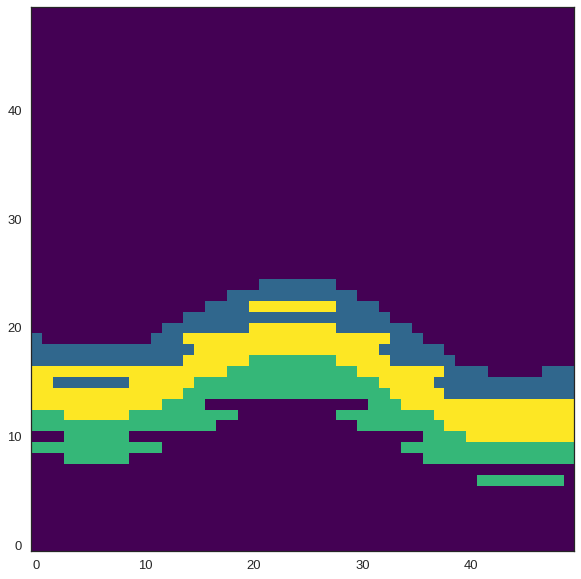

In [360]:
plt.imshow(diagram2.T, origin='bottom', cmap='viridis')

In [76]:
### Trying to reduce intersection area to an intersection line
intersect = get_lith_fault_intersect(v_f,v_l)[0]
p_max = get_extrema_line_voxels(fwMM, ext_type='max', projection='yz')
maxpos_fw = np.argwhere(p_max==True)
possum_fw = np.sum(maxpos_fw, axis=0)
emptypos_fw = np.argwhere(possum_fw==0)
maxpos_fw_red = np.delete(maxpos_fw, emptypos_fw, 1)
inters_fw_red = np.delete(intersect, 0, 1)
maxpos_fw_rescaled = maxpos_fw_red*vox_size_x

In [148]:
mi_dist = distance.cdist(maxpos_fw_rescaled, inters_fw_red)
mi_min_pos = np.argmin(mi_dist, axis=1)
min_dist = np.min(mi_dist, axis=0)
mi_cut_bool = min_dist < (vox_size_diag/1000)
#mi_cut_bool = np.logical_and(np.round(min_dist), np.round(mi_dist))
mi = intersect[mi_cut_bool]

In [203]:
import scipy
comp_order = np.int(np.round(((geo_data.resolution[0]+geo_data.resolution[1])/2)/2))
fmimaxpos_fw = sg.find_peaks_cwt(mi[:,2], widths=[4])#np.array([comp_order*2]))
mi_max=mi[fmimaxpos_fw]

mapo = sg.argrelextrema(mi[:,2], np.greater_equal, order=30)
mi_max2=mi[mapo]

In [204]:
print(mi_max, mi_max2)

print(np.max(mi[:,2]))

[[  600.          1640.           640.        ]
 [  626.66927338    80.           720.        ]
 [  680.           680.           880.        ]
 [  706.66931152  1040.           960.        ]] [[  706.66931152   840.           960.        ]
 [  706.66931152   880.           960.        ]
 [  706.66931152   920.           960.        ]
 [  706.66931152   960.           960.        ]
 [  706.66931152  1000.           960.        ]
 [  706.66931152  1040.           960.        ]
 [  706.66931152  1080.           960.        ]]
960.0


In [232]:
def get_layer_fault_contact(fault_vertices, layer_vertices, voxel_array, \
                            projection='yz', fault_side='footwall'):
    if projection == 'automatic':
        d_x = (np.max(voxel_array[:,0])-np.min(voxel_array[:,0]))
        d_y = (np.max(voxel_array[:,1])-np.min(voxel_array[:,1]))
        if d_x > d_y: 
            projection = 'xz'
        else:
            projection = 'yz'
    if projection == 'yz':
        p = 0
    elif projection == 'xz':
        p = 1
    else:
        print('Projection plane should be yz, xz or automatic.')
        p=0   
    intersection_surface = get_lith_fault_intersect(fault_vertices,layer_vertices)[0]
    maxline_vox = get_extrema_line_voxels(voxel_array, ext_type='max', projection=projection)
    maxpos_vox = np.argwhere(maxline_vox==True)
    # rescaling
    maxpos_vox[:,0] = maxpos_vox[:,0] * vox_size_x
    maxpos_vox[:,1] = maxpos_vox[:,1] * vox_size_y
    maxpos_vox[:,2] = maxpos_vox[:,2] * vox_size_z
    maxpos_vox_red = np.delete(maxpos_vox, p, 1)
    intersection_red = np.delete(intersection_surface, p, 1)
    mi_dist = distance.cdist(maxpos_vox_red, intersection_red)
    min_dist = np.min(mi_dist, axis=0)
    mi_cut_bool = min_dist < (vox_size_diag/1000)
    top_line = intersection_surface[mi_cut_bool]
    return top_line

def get_contact_peaks(fault_vertices, layer_vertices, voxel_array, \
                            projection='yz', fault_side='footwall', \
                      order=np.int(np.round(((geo_data.resolution[0]+geo_data.resolution[1])/2)/2))):
    top_line = get_layer_fault_contact(fault_vertices, layer_vertices, voxel_array, \
                            projection=projection, fault_side=fault_side)
    relmaxpos = sg.argrelextrema(top_line[:,2], np.greater_equal, order=order)
    peaks = top_line[relmaxpos]
    return peaks
    

mi2 = get_layer_fault_contact(v_f, v_l, fwMM, \
                            projection='yz', fault_side='footwall')
mi = get_layer_fault_contact(v_f, v_l, hwMM, \
                            projection='yz', fault_side='footwall')
mi_max2 = get_contact_peaks(v_f, v_l, fwMM)
mi_max = get_contact_peaks(v_f, v_l, hwMM)

z_diff = np.max(mi_max2[:,2]) - np.max(mi_max[:,2])

In [233]:
z_diff

80.0

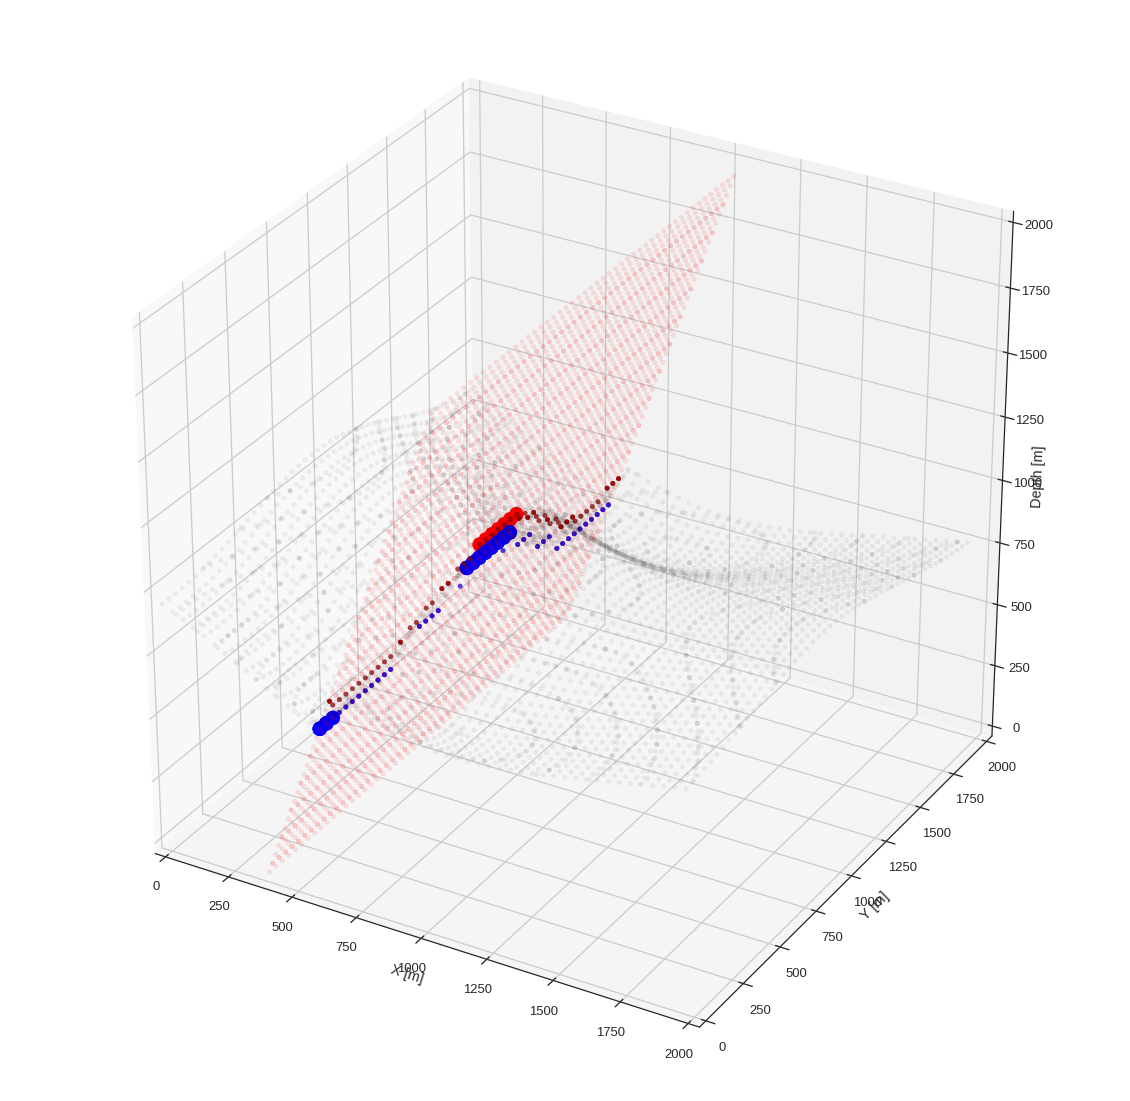

In [247]:
%matplotlib inline
figsize(20,20)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(v_l[:, 0], v_l[:, 1], v_l[:, 2], color='k', alpha=0.05)
ax.scatter(v_f[:, 0], v_f[:, 1], v_f[:, 2], color='r', alpha=0.1)
ax.scatter(mi2[:, 0], mi2[:, 1], mi2[:, 2], color='maroon', alpha=0.7)
ax.scatter(mi[:, 0], mi[:, 1], mi[:, 2], color='blue', alpha=0.7)
ax.scatter(mi_max[:,0], mi_max[:, 1], mi_max[:, 2], color='blue', alpha=1,s=200)
ax.scatter(mi_max2[:,0], mi_max2[:,1], mi_max2[:,2], color='red', alpha=1,s=200)

ax.set_xlim(geo_data.extent[0], geo_data.extent[1])
ax.set_ylim(geo_data.extent[2], geo_data.extent[3])
ax.set_zlim(geo_data.extent[4], geo_data.extent[5])
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Depth [m]')
plt.show()

In [68]:
vox_size_x = np.abs(geo_data.extent[1] - geo_data.extent[0]) / geo_data.resolution[0]
vox_size_y = np.abs(geo_data.extent[3] - geo_data.extent[2]) / geo_data.resolution[1]
vox_size_z = np.abs(geo_data.extent[5] - geo_data.extent[4]) / geo_data.resolution[2]
vox_size_diag = np.sqrt(vox_size_x ** 2 + vox_size_y ** 2 + vox_size_z ** 2)

contact_up = get_lith_fault_intersect(v_f,v_l)[0]
contact_low = get_lith_fault_intersect(v_f,v_l2)[0]
#contact = np.vstack((contact_up, contact_low))
contact = v_f
#contact = contact_low
hwc = hwMM
fwc = fwMM
#jxp = get_fault_juxtapos(geo_data, lith_sol, fault_sol, fault_n=1)

if np.any(hwc):

    hwc_coord0 = np.argwhere(hwc == True)

    hwc_coord = hwc_coord0
    hwc_coord[:, 0] = (hwc_coord0[:, 0] * vox_size_x) + geo_data.extent[0]  #+ vox_size_x/2
    hwc_coord[:, 1] = (hwc_coord0[:, 1] * vox_size_y) + geo_data.extent[2]  #+ vox_size_y/2
    hwc_coord[:, 2] = (hwc_coord0[:, 2] * vox_size_z) + geo_data.extent[4]  #+ vox_size_z/2
    dist_hwc = distance.cdist(contact, hwc_coord, 'euclidean')

    min_dist_hwc = np.min(dist_hwc, axis=1)
    cut_bool_hwc = min_dist_hwc < (vox_size_diag / 1)
    contact_hwc_all = contact[cut_bool_hwc]
    
if np.any(fwc):

    fwc_coord0 = np.argwhere(fwc == True)

    fwc_coord = fwc_coord0
    fwc_coord[:, 0] = (fwc_coord0[:, 0] * vox_size_x) + geo_data.extent[0] #+ vox_size_x/2
    fwc_coord[:, 1] = (fwc_coord0[:, 1] * vox_size_y) + geo_data.extent[2] #+ vox_size_y/2
    fwc_coord[:, 2] = (fwc_coord0[:, 2] * vox_size_z) + geo_data.extent[4] #+ vox_size_z/2

    dist_fwc = distance.cdist(contact, fwc_coord, 'euclidean')

    min_dist_fwc = np.min(dist_fwc, axis=1)
    cut_bool_fwc = min_dist_fwc < (vox_size_diag / 1)
    contact_fwc_all = contact[cut_bool_fwc]
    
    # voxel correction:
    # + for HWC as voxels should be always "right" of the fault and the opposite for FWC,
    # but I am not 100 % shure if this is correct,
    # other option, add half a voxel to all for centralized spread
    # (else it is "left-shifted", I think)
#if np.any(jxp):
#
#    jxp_coord0 = np.argwhere(jxp == True)
#
#    jxp_coord = jxp_coord0
#    jxp_coord[:, 0] = (jxp_coord0[:, 0] * vox_size_x) + geo_data.extent[0] #+ vox_size_x/2
#    jxp_coord[:, 1] = (jxp_coord0[:, 1] * vox_size_y) + geo_data.extent[2] #+ vox_size_y/2
#    jxp_coord[:, 2] = (jxp_coord0[:, 2] * vox_size_z) + geo_data.extent[4] #+ vox_size_z/2
    
    # no voxel correction for juxtapos, as they are created from "overlap"
    # however, need to rethink if this overlap is really the correct juxtaposition,
    # as z-directed rolling of voxels might create
    # extra voxels...
    
    #dist_jxp = distance.cdist(contact, jxp_coord, 'euclidean')

    #min_dist_jxp = np.min(dist_jxp, axis=1)
    #cut_bool_jxp = min_dist_jxp < (vox_size_diag / 2)
    #contact_jxp_all = contact[cut_bool_jxp]

In [71]:
print('FW:')
print(np.max(contact_up[:,2]), np.max(contact_fwc_all[:,2]))
print(np.min(contact_up[:,2]), np.min(contact_fwc_all[:,2]))
print('HW:')
print(np.max(contact_low[:,2]), np.max(contact_hwc_all[:,2]))
print(np.min(contact_low[:,2]), np.min(contact_hwc_all[:,2]))

### --> INACCURACY PROBLEM!?

FW:
1000.0 1000.0
520.0 360.0
HW:
720.0 920.0
240.0 200.0


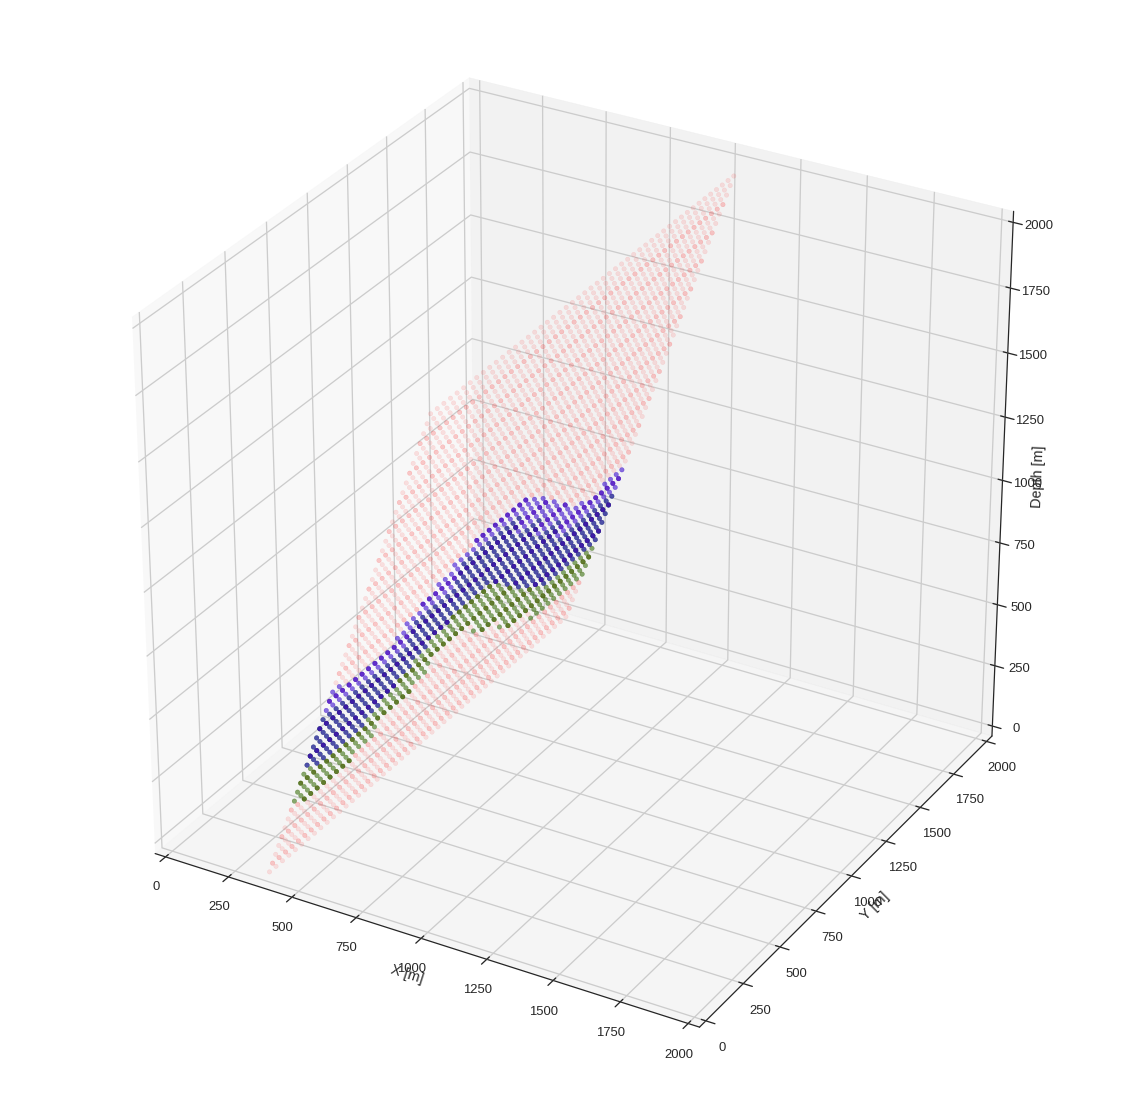

In [70]:
%matplotlib inline
figsize(20,20)

intersect_upper = get_lith_fault_intersect(v_f,v_l)[0]
intersect_lower = get_lith_fault_intersect(v_f,v_l2)[0]

#intersect_minima_all, intersect_maxima_all, intersect_saddles_all \
#        = sp.get_surface_extrema(geo_data, v_l, GX, GY)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(v_l[:, 0], v_l[:, 1], v_l[:, 2], color='k', alpha=0.05)
ax.scatter(v_f[:, 0], v_f[:, 1], v_f[:, 2], color='r', alpha=0.1)
ax.scatter(contact_hwc_all[:, 0], contact_hwc_all[:, 1], contact_hwc_all[:, 2], color='green', alpha=0.5)
ax.scatter(contact_fwc_all[:, 0], contact_fwc_all[:, 1], contact_fwc_all[:, 2], color='blue', alpha=0.5)
#ax.scatter(contact_jxp_all[:, 0], contact_jxp_all[:, 1], contact_jxp_all[:, 2], color='maroon', alpha=0.8)
#ax.scatter(intersect[:, 0], intersect[:, 1], intersect[:, 2], color='maroon', alpha=0.7)

#if len(intersect_minima_all) > 0:
#    ax.scatter(intersect_minima_all[:, 0], intersect_minima_all[:, 1], intersect_minima_all[:, 2], \
#               color='blue',s=200, marker='o')
#if len(intersect_maxima_all) > 0:
#    ax.scatter(intersect_maxima_all[:,0],intersect_maxima_all[:,1],intersect_maxima_all[:,2],\
#               color='r', s=200, marker='o')
#if len(intersect_saddles_all) > 0:
#    ax.scatter(intersect_saddles_all[:, 0], intersect_saddles_all[:, 1], intersect_saddles_all[:, 2], \
#               color='violet',s=200, marker='o')

ax.set_xlim(geo_data.extent[0], geo_data.extent[1])
ax.set_ylim(geo_data.extent[2], geo_data.extent[3])
ax.set_zlim(geo_data.extent[4], geo_data.extent[5])
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Depth [m]')
plt.show()

In [18]:
# LITHOLOGY BLOCK MASKING FUNCTIONS

# Masking function that confines to voxels which are part fo the reservoir formation,
# in the footwall side and above the z-horizontal defined by the spill or leak point
def res_mask(lith,fault, bottom_z, formation_bool, fault_bool):
    mask = np.ones_like(lith)
    mask[~formation_bool] = False
    mask[fault_bool] = False
    #mask[fault.astype(bool)] = False
    bottom_z = round((bottom_z/scale_factor)+0.5) #rounding up to avoid voxel connection to outside borders
    mask = mask.reshape(resolution,resolution,resolution)
    mask[:,:,:bottom_z] = False
    mask = mask.reshape(resolution**3,)
    return mask

def topo_analysis(lith, fault, seal_th):
    traps = []
    SSF = 0
    trap_control = 0
    # Padding of lith- and fault-block (creating border sections, formation number = 8)
    lith_pad = (np.pad(lith.reshape(resolution,resolution,resolution), 1, 'constant', constant_values = (8,8)))
    fault_pad = (np.pad(fault.reshape(resolution,resolution,resolution), 1, 'constant', constant_values = (8,8)))
    G, centroids, labels_unique, lith_to_labels_lot, labels_to_lith_lot, topo_block = \
    gp.topology.topology_analyze(lith_pad, fault_pad, 1, areas_bool=False, return_block=True)
    # Finding sections which are possible traps in the reservoir (formation number = 7)
    trap_keys = [int(k) for k in lith_to_labels_lot["7"].keys()] # potential trap sections
    pad_keys = [int(p) for p in lith_to_labels_lot["8"].keys()] # model border sections
    base_keys = [int(b) for b in lith_to_labels_lot["%s" % base_n].keys()]
    res_keys = [int(r) for r in lith_to_labels_lot["%s" % res_n].keys()]
    secres_keys = [int(j) for j in lith_to_labels_lot["%s" % secres_n].keys()] # sections in Secondary Reservoir
    over_keys = [int(o) for o in lith_to_labels_lot["%s" % over_n].keys()] # section in Overlying
    tot_under_keys = np.append(res_keys, base_keys) # all sections that belong to underlying below seal
    tot_over_keys = np.append(secres_keys, over_keys) # all sections that belong to overlying above seal
    bool_block = np.zeros_like(topo_block)
    gp.topology.classify_edges(G, centroids, lith.reshape(50,50,50), fault.reshape(50,50,50))   
    # If too many traps, model probably broken:
    print("NUMBER OF TRAPS", len(trap_keys))
    if len(trap_keys) > 10:
        trap_mask = bool_block[1:-1,1:-1,1:-1]
        SSF = 0
        trap_control = 0
        return trap_mask, SSF, trap_control
    else:
        # Check for each possible trap section, if it is connected to a border
        for tk in trap_keys:
            print('Checking Section:', tk)
            # Check for adjacency to model border
            if gp.topology.check_adjacency(G, tk, pad_keys[0]) == False:
                # Check for connection (juxtaposition!) to overlying layers (above seal) and SSF
                fault_seal_bool, SSF, trap_control = juxta_SSF_check(G, tk, res_keys, tot_under_keys, tot_over_keys, topo_block, seal_th)
                if fault_seal_bool == True:
                    traps.append(tk)
                    print('TRAP:', tk)
        if traps == []:
            print('No trap found! =(')
        else:
            for i in traps:
                # Creating a mask from the trap sections in the label block
                top_bool = topo_block == i
                bool_block[top_bool] = True
        # Removing padding
        trap_mask = bool_block[1:-1,1:-1,1:-1]
        return trap_mask, SSF, trap_control # this mask returns True for all voxels which were accepted as trap voxels

In [46]:
def juxta_SSF_check(G, tk, res_keys, tot_under_keys, tot_over_keys, topo_block, seal_th):
    throw = 0
    jp=0
    trap_c = 4
    # FIRST: check the adjacency area only for the trap: only the point of highest throw is relevant for SSF
    for tk in res_keys:
        for ok in tot_over_keys:  
            if gp.topology.check_adjacency(G, tk, ok) == True:
                if G.adj[tk][ok]['edge_type'] == 'stratigraphic':
                    print("Stratigraphic adjacency, leakage assumed!")
                    sealing = False
                    SSF = 0
                    trap_c = 4
                    return sealing, SSF, trap_c         # stratigraphic adjancency assumed to always leak 
                elif G.adj[tk][ok]['edge_type'] == 'fault':
                    #print('TEST0', gp.Topology.compute_adj_shape(tk,ok,topo_block).shape)
                    #print('TEST1', gp.Topology.compute_adj_shape(tk,ok,topo_block))
                    #print('TEST2', gp.Topology.compute_adj_shape(tk,ok,topo_block)[3])
                    #TEST = gp.Topology.compute_adj_shape(tk,ok,topo_block)
                    #print('TEST:', TEST)
                    trap_jshape = gp.topology.compute_adj_shape(tk,ok,topo_block)[3]
                    # fault throw at edge of trap section
                    if trap_jshape !=0:
                        y_ext = trap_jshape[1]
                        z_ext = trap_jshape[2]
                        # finding point of greatest throw for trap --> relevant for total fault throw and SSF
                        # bottom of trap is flat, so need to find only highest z-values for juxtaposition:
                        z_max = max(z_ext)
                        # finding the y.axis range in which this highest throw appears:
                        y_range = y_ext[z_ext==z_max]
                        y_min = min(y_range)
                        y_max = max(y_range)
                        jp+=1
                        
    # SECOND: check for adjancencies between all seal-underlying and seal-overlying formations to
    # determine total fault throw at point/range defined over trap (y_bool)
    if jp != 0:
        for uk in tot_under_keys:
            for ok in tot_over_keys:  
                if gp.topology.check_adjacency(G, uk, ok) == True:
                    #print("Adjacency with section:", ok)
                    if G.adj[uk][ok]['edge_type'] == 'stratigraphic':
                        print("Stratigraphic adjacency, leakage assumed!")
                        sealing = False
                        SSF = 0
                        trap_c = 4
                        return sealing, SSF, trap_c     # stratigraphic adjancency assumed to always leak
                    elif G.adj[uk][ok]['edge_type'] == 'fault':
                        # get the array for z-extent for this adj-area, then mask to relevant range
                        section_jshape = gp.topology.compute_adj_shape(uk,ok,topo_block)[3]
                        if section_jshape != 0:
                            section_z_ext = section_jshape[2]
                            # creating mask where values within this range = True --> to appl
                            section_y_ext = section_jshape[1]
                            y_ext_bool = np.logical_and(section_y_ext>=y_min, section_y_ext<=y_max)
                            y_bool_mask = np.copy(section_y_ext)
                            y_bool_mask[~y_ext_bool] = False
                            y_bool_mask[y_ext_bool] = True
                            if np.count_nonzero(y_bool_mask) != 0:
                                # the following can be used to find the throw height for one area
                                y_bool = y_bool_mask==True
                                section_z_range = section_z_ext[y_bool]
                                # get the throw height:
                                z_len = max(section_z_range)-min(section_z_range)+1
                                # calculate throw in [m] for this adjacency and add to total
                                section_throw = z_len*scale_factor
                                throw += section_throw
                                print("Adding %s to throw, adjacency between %s and %s" % (section_throw, uk, ok))
                                jp+=1
    if jp == 0:
        print('No JP with any layer over seal.')
        SSF = 0
        sealing = True
        trap_c = 0
        return sealing, SSF, trap_c
    else:
        print('JP with layer over seal, checking SSF.')
        tot_fault_throw = throw + seal_th
        SSF = tot_fault_throw/seal_th
        print('SSF = %s / %s = %s' % (tot_fault_throw, seal_th, SSF))
        if SSF > SSF_c:
            print('SSF threshold exceeded, shale smear assumed to be incomplete.')
            sealing = False
            trap_c = 3
            return sealing, SSF, trap_c
        else: 
            print('SSF in confidence range, complete shale smear sealing assumed.')
            sealing = True
            trap_c = 0
            return sealing, SSF, trap_c

In [47]:
# MAIN FUNCTION: Calculation of maximum fill volume in reservoir traps

def max_trap_vol(interp_data, lith, fault, res_surface, seal_th):
    trap_control = 0 # intitiating variable that indicates what kind of mechanism controls the trap volume
                        # 0 = Unclear
                        # 1 = Spill Point
                        # 2 = Leak Point (LEAK UNDER)
                        # 3 = Seal breach juxtaposition leakage (LEAK OVER)
                        # 4 = Stratigraphical adjacency leakage 
    spill_point, leak_point = spill_leak_P(interp_data, res_surface, lith, fault, print_figures=False)
    print("SPILL POINT AT:", spill_point)
    print("LEAK POINT AT:", leak_point)
    #CHECK: ONLY CONTINUE IF SPILL POINT FOUND, ELSE RETURN ZERO TRAP VOLUME
    if spill_point.size == 0:
        spill_z = np.nan
        print('No SPILL POINT found!')
        trap_vol = 0
        final_trap_mask = np.zeros_like(lith)
        return trap_vol, final_trap_mask, np.nan, 0    
    else:
        spill_z = spill_point[2]
        #spill_z, spill_p, spill_min_line, spill_bottom = spill_point(res_surface)
        # calculate leak point
        if leak_point.size == 0:
            print('No LEAK POINT found! So FULL LEAKAGE assumed!')
            leak_z = 2000
        else:
            leak_z = leak_point[2]
        #leak_z, leak_p, leak_line, leak_bottom = leak_point(res_surface)
        
        # Check for "down-to" z-horizon, maximum depth of reservoir
        # Check for fault sealing and subsequent relevance of leak point
        max_z = np.nanmax([spill_z, leak_z])   
        if max_z == spill_z:
            trap_control = 1
        else:
            trap_control = 2                
        
        rounded_lith = np.around(lith).astype(int)
        rounded_fault = np.around(fault).astype(int)
        res_n_bool = rounded_lith == res_n
        fault_bool = rounded_lith == 2
        
        pre_trap_mask = res_mask(lith, fault, max_z, res_n_bool, fault_bool)
          
        # volume cells for counting
        vol_cells = 0
        lith_copy = np.copy(lith)
        
        pre_trap_mask_bool = (pre_trap_mask == True)
        # Check if there is anaything in the reservoir mask at all
        if np.count_nonzero(pre_trap_mask_bool) == 0:
            print("No res_formation above max_z!")
            SSF = 0
            trap_control = 0
            return 0, pre_trap_mask, SSF, trap_control
        else:
            lith_copy[pre_trap_mask_bool] = 7                           # setting reservoir above bottom on footwall side 
            final_trap_mask, SSF, trap_c = topo_analysis(lith_copy, fault, seal_th)
            if trap_c == 3:
                trap_control = trap_c
            elif trap_c == 4:
                trap_control = trap_c
            lith_copy[final_trap_mask] = 9                         # setting final trap to formation value = 9
            vol_cells = np.count_nonzero(final_trap_mask)
            
            #calulate volume from cells
            trap_vol = ((scale_factor)**3) * vol_cells 
            # revert to lith_block without any masks
            #lith[pre_trap_mask_bool] = res_n      
            #return the maximum reservoir volume
            return trap_vol, final_trap_mask, SSF, trap_control

In [48]:
# PLOTTING FUNCTIONS: Spill and leak point visualization
def plot_spill_leak(res_surface, pot_spills, spill_point, leak_point, grid_x, grid_y, grid_z0):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(grid_x, grid_y, grid_z0, c="b", alpha = 0.1)
    #ax.scatter(grid_x, grid_y,pot_spills, c="r", alpha = 1, marker='p', s = 250)
    if spill_point.size != 0:        
        ax.scatter(spill_point[0],spill_point[1],spill_point[2], c="black", alpha = 1, marker='x', s = 250)
    if leak_point.size != 0:        
        ax.scatter(leak_point[0],leak_point[1],leak_point[2], c="black", alpha = 1, marker='+', s = 250)
        
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    plt.show()

In [49]:
# for setting up postional conditions to determine thicknesses and the like:
fw_th_point = 900 # distance of test point for thickness from footwall border of model 
                  # (e.g.: X = 2000 - 900 = 1100)
HW_border = 1300 # distance of middle of fault (border HW/FW) from footwall border of model
                # (X = 2000 - 1300 = 700)

# SAVING ORIGINAL Z-VALUES (so they are not overwritten and can be used a base for every iteration)    
sec_res_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'SecRes_Top']['Z']
seal_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Seal_Top']['Z']
res_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Res_Top']['Z']
base_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Base_Top']['Z']

# SETTING Z-UNCERTAINTIES FOR EACH LAYER TOP
unc_f = 1
std_secres_top = 40 #* unc_f
std_seal_top = 60 #* unc_f
std_res_top = 80 #* unc_f
std_base_top = 100 #* unc_f
z_unc_secres_top = pymc.Normal('z_unc_secres_top', 0, 1./np.square(std_secres_top/rescale_f))
z_unc_seal_top = pymc.Normal('z_unc_seal_top', 0/rescale_f, 1./np.square(std_seal_top/rescale_f))
z_unc_res_top = pymc.Normal('z_unc_res_top', 0, 1./np.square(std_res_top/rescale_f))
z_unc_base_top = pymc.Normal('z_unc_base_top', 0, 1./np.square(std_base_top/rescale_f))

# SETTING FAULT OFFSET UNCERTAINTY
std_offset = 20 #150
# using SkewNormal, so that fault offset is much more like to vary to a higher offset and to stay as a normal fault
offset_unc = pymc.SkewNormal('offset_unc', -10/rescale_f, 1./np.square(std_offset/rescale_f), alpha=-2)
#offset_unc = pymc.SkewNormal('offset_unc', -100/rescale_f, 1./np.square(std_offset/rescale_f), alpha=-2)

# GENERAL FAULT SEALING UNCERTAINTY (p = probability of success (1 = True); True = fault sealing) # NOT USED!
#fault_sealing = pymc.Bernoulli('fault_sealing_unc',p=0)

In [50]:
# Boolean conditions to find data points for each formation
base_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Base_Top'
res_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Res_Top'
seal_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Seal_Top'
secres_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'SecRes_Top'

# Footwall and hanging wall conditions
footwall = interp_data.geo_data_res.interfaces['fault side'] == 'footwall'
hanging_wall = interp_data.geo_data_res.interfaces['fault side'] == 'hanging wall'

# Combining hanging wall and formation conditions
HW_secres_top = np.logical_and(secres_top_cond,hanging_wall)
HW_seal_top = np.logical_and(seal_top_cond,hanging_wall)
HW_res_top = np.logical_and(res_top_cond,hanging_wall)
HW_base_top = np.logical_and(base_top_cond,hanging_wall)

Z variations top to bottom: -50.5488423507 69.2531349981 -10.0004726873 85.8595006782
Fault offset variation: -21.1777746689


/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:56: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:67: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:68: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Serie

SPILL POINT AT: [ 1360.          920.          874.5715332]
LEAK POINT AT: [ 640.          960.          860.36857605]
NUMBER OF TRAPS 4
Checking Section: 4
Checking Section: 14
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 14
Checking Section: 16
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 16
Checking Section: 19
Maximum trap volume: 22656000.0 m³


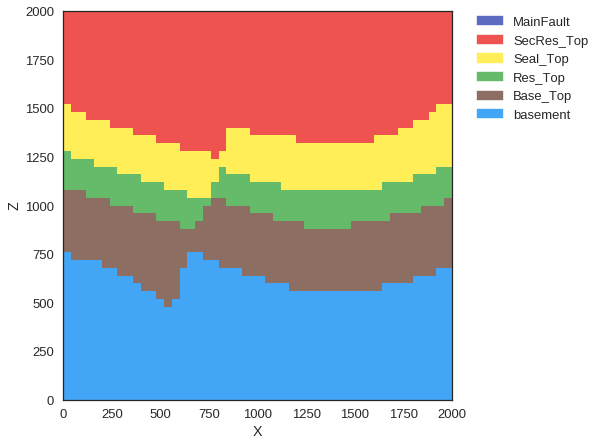

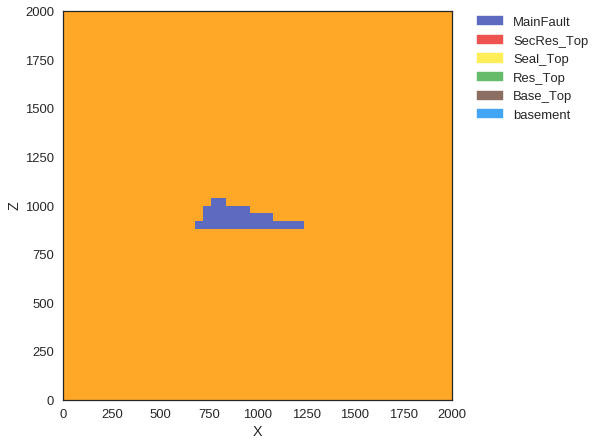

In [65]:
# PYMC MODEL FUNCTIONS 

# Updating of interp_data points with new z-values resulting from z-positional uncertainty
# and including offset uncertainty:
@pymc.deterministic
def interp_unc(value=0, z_unc_secres_top = z_unc_secres_top, z_unc_seal_top=z_unc_seal_top, 
                  z_unc_res_top = z_unc_res_top, z_unc_base_top = z_unc_base_top, off_unc=offset_unc):
    #print('CHECK0:', res_z)
    new_z_secres_top = sec_res_z + z_unc_secres_top
    new_z_seal_top = seal_z + z_unc_seal_top
    new_z_res_top = res_z + z_unc_res_top
    new_z_base_top = base_z + z_unc_base_top   
    
    # for offset uncertainty: additional change on hanging wall (HW): 
    HW_new_z_secres_top = new_z_secres_top + off_unc
    HW_new_z_seal_top = new_z_seal_top + off_unc
    HW_new_z_res_top = new_z_res_top + off_unc
    HW_new_z_base_top = new_z_base_top + off_unc

    print('Z variations top to bottom:', z_unc_secres_top*rescale_f, 
          z_unc_seal_top*rescale_f, z_unc_res_top*rescale_f, z_unc_base_top*rescale_f)  
    print('Fault offset variation:', off_unc*rescale_f)
    
    # FOOTWALL UNCERTAINTY
    interp_data.geo_data_res.interfaces.loc[secres_top_cond,'Z'] = new_z_secres_top
    interp_data.geo_data_res.interfaces.loc[seal_top_cond,'Z'] = new_z_seal_top
    interp_data.geo_data_res.interfaces.loc[res_top_cond,'Z'] = new_z_res_top
    interp_data.geo_data_res.interfaces.loc[base_top_cond,'Z'] = new_z_base_top

    # HANGING WALL UNCERTAINTY (incl. offset)
    interp_data.geo_data_res.interfaces.loc[HW_secres_top,'Z'] = HW_new_z_secres_top
    interp_data.geo_data_res.interfaces.loc[HW_seal_top,'Z'] = HW_new_z_seal_top
    interp_data.geo_data_res.interfaces.loc[HW_res_top,'Z'] = HW_new_z_res_top
    interp_data.geo_data_res.interfaces.loc[HW_base_top,'Z'] = HW_new_z_base_top
    
    #print('CHECK3:', interp_data.geo_data_res.interfaces)    
    return interp_data

# Calculating formation thickness based on z-difference between a bottom and top point on the footwall (fw)

# This is done using interp_data, where X,Y and Z-values are rescaled according to the rescaling_factor.
# Value[1] of extent_rescaled equals the maximum extent of model (here: 2000).
# So if we want to find the rescaled chosen X-position (here: 1100), 
# we simply calculate 2000-fw_th_point(here:900) rescaled (see fw_x)
# Y_mid defines that we are looking at a central position (in y-direction) in the model.
# The difference in z between two points has to be rescaled to the original scale again.
#rescale_f = interp_data.rescaling_factor

# Reservoir thickness
@pymc.deterministic
def res_th(interp_data=interp_unc):
    fw_x = interp_data.geo_data_res.interfaces['X'] == (interp_data.geo_data_res.extent[1] - (fw_th_point/rescale_f))
    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.geo_data_res.extent[3] - (1000/rescale_f))
    points_fw = interp_data.geo_data_res.interfaces[fw_x]
    points_fw = points_fw[y_mid] 
    fw_rb_z = points_fw[base_top_cond]['Z'].values*rescale_f
    fw_sb_z = points_fw[res_top_cond]['Z'].values*rescale_f
    return np.abs(fw_sb_z-fw_rb_z)

#Seal thickness
@pymc.deterministic
def seal_th(interp_data=interp_unc):
    fw_x = interp_data.geo_data_res.interfaces['X'] == (interp_data.geo_data_res.extent[1] - (fw_th_point/rescale_f))
    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.geo_data_res.extent[3] - (1000/rescale_f))
    # .extent[1] = 'X'-max; .extent[3] = 'Y'-max
    points_fw = interp_data.geo_data_res.interfaces[fw_x]
    points_fw = points_fw[y_mid] 
    fw_r2b_z = points_fw[seal_top_cond]['Z'].values*rescale_f
    fw_sb_z = points_fw[res_top_cond]['Z'].values*rescale_f
    return np.abs(fw_r2b_z-fw_sb_z)

# Secondary reservoir thickness
@pymc.deterministic
def sec_res_th(interp_data=interp_unc):
    fw_x = interp_data.geo_data_res.interfaces['X'] == (interp_data.geo_data_res.extent[1] - (fw_th_point/rescale_f))
    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.geo_data_res.extent[3] - (1000/rescale_f))
    points_fw = interp_data.geo_data_res.interfaces[fw_x]
    points_fw = points_fw[y_mid] 
    fw_r2b_z = points_fw[seal_top_cond]['Z'].values*rescale_f
    fw_ob_z = points_fw[secres_top_cond]['Z'].values*rescale_f
    return np.abs(fw_ob_z-fw_r2b_z)             

# Volumetric calculation 
@pymc.deterministic
def structural_model(interp_data_M=interp_unc, seal_th=seal_th,
                     lh=lith_holder, fh=fault_holder, idh=interp_holder, seal_n=seal_n, print_figures=True):
    try:
        lith_sol, fault_sol = gp.compute_model(interp_data_M)
        lith_block = lith_sol[0]
        fault_block = fault_sol[0]  
        seal_surf_v, seal_surf_s = gp.get_surfaces(\
            interp_data = interp_data_M, potential_lith=lith_sol[1], 
            potential_fault=fault_sol[1], n_formation = seal_n)
        max_vol, trap, SSF, trap_control = max_trap_vol(interp_data_M, lith_block, fault_block, seal_surf_v, seal_th)
        print("Maximum trap volume: %s m³" % max_vol)
        if print_figures:
            plt.figure(1)
            gp.plotting.plot_section(geo_data, lith_sol[0], int(resolution/2), plot_data =0)
            plt.figure(2)
            gp.plotting.plot_section(geo_data, trap, int(resolution/2), plot_data =0)
        return lith_sol, fault_sol, max_vol, trap, SSF, trap_control
        #return max_vol, SSF, trap_control
        
    except np.linalg.linalg.LinAlgError as err:
        # In case of LinAlgError, use original model
        print('LinAlgError occurred!')
        lith_sol = lh
        fault_sol = fh
        lith_block = lith_sol[0]
        fault_block = fault_sol[0] 
        seal_surf_v, seal_surf_s = gp.get_surfaces(
                                              interp_data = interp_data_M, potential_lith=lith_sol[1], 
            potential_fault=fault_sol[1], n_formation = seal_n)
        max_vol, trap, SSF, trap_control = max_trap_vol(idh, lith_block, fault_block, seal_surf_v, seal_th)
        print("Maximum trap volume: %s m³" % max_vol)
        return lith_sol, fault_sol, max_vol, trap, SSF, trap_control
        #return max_vol, SSF, trap_control
    
    ### RETURN INDICES:
    ### 0 = lith_sol
    ### 1 = fault_sol
    ### 2 = max_vol (maximum trap volume)
    ### 3 = trap (block)
    ### 4 = SSF (Shale Smear Factor)
    ### 5 = trap_control (controling mechanism for max trap volume)

In [60]:
iterations = 20

In [61]:
model = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc, structural_model, res_th, seal_th, sec_res_th])
#model = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc, structural_model, res_th, seal_th, sec_res_th, over_jux_area])

Z variations top to bottom: -19.938836246 70.859030264 -45.9213989886 17.0013033698
Fault offset variation: -49.4309814922
BOOL CHECK 2
BOOL CHECK 1
BOOL CHECK 3
BOOL CHECK 3b


/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:68: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:56: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:80: UserWarning: Boolean Serie

BOOL CHECK 4
SPILL POINT AT: 

/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:75: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if sys.path[0] == '':


[ 1320.          920.          902.3009491]
LEAK POINT AT: [ 640.          960.          869.87388611]
NUMBER OF TRAPS 3
Checking Section: 4
Checking Section: 16
Adding 40.0 to throw, adjacency between 12 and 6
JP with layer over seal, checking SSF.
SSF = [ 378.38083738] / [ 338.38083738] = [ 1.11821]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 16
Checking Section: 19
Maximum trap volume: 15872000.0 m³
 [---              10%                  ] 2 of 20 complete in 12.0 secZ variations top to bottom: -70.1199787656 -99.5314780976 113.123480257 2.52352087534
Fault offset variation: -1.99276100468
BOOL CHECK 2
BOOL CHECK 1
BOOL CHECK 3
BOOL CHECK 3b
BOOL CHECK 4
SPILL POINT AT: [ 1400.           920.           872.16239929]
LEAK POINT AT: [ 640.          960.          861.39595032]
NUMBER OF TRAPS 4
Checking Section: 7
Checking Section: 16
Adding 40.0 to throw, adjacency between 11 and 4
JP with layer over seal, checking SSF.
SSF = [ 48.94544977] / [ 8.94544977] = 

 [-----------------60%--                ] 12 of 20 complete in 132.8 secZ variations top to bottom: -13.1879812024 91.7617658493 -24.5327874065 10.6222463379
Fault offset variation: -27.9920825742
BOOL CHECK 2
BOOL CHECK 1
BOOL CHECK 3
BOOL CHECK 3b
BOOL CHECK 4
SPILL POINT AT: [ 1320.           920.           880.83732605]
LEAK POINT AT: [ 640.          960.          869.09416199]
NUMBER OF TRAPS 3
Checking Section: 4
Checking Section: 15
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 15
Checking Section: 18
Maximum trap volume: 11712000.0 m³
 [-----------------65%----              ] 13 of 20 complete in 145.1 secZ variations top to bottom: -63.8573555991 5.17354165695 9.74806780264 -2.50474721912
Fault offset variation: -26.9443356384
BOOL CHECK 2
BOOL CHECK 1
BOOL CHECK 3
BOOL CHECK 3b
BOOL CHECK 4
SPILL POINT AT: [ 1360.           920.           881.57722473]
LEAK POINT AT: [ 640.          960.          858.18374634]
NUMBER OF TRAPS 3
Checking Section:

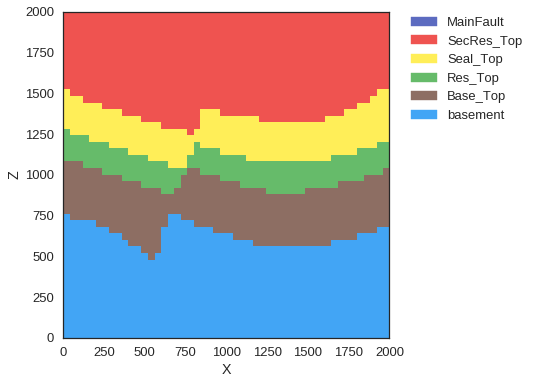

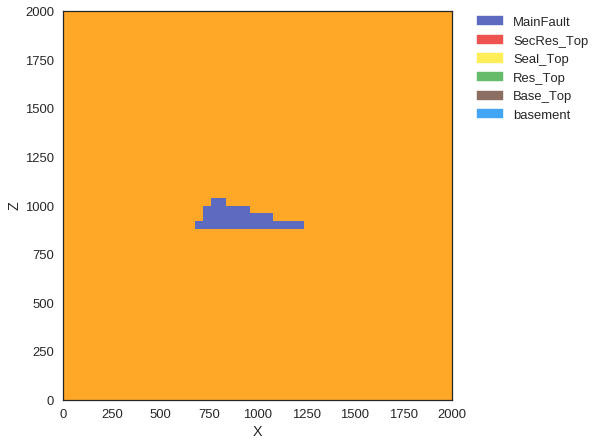

In [62]:
M = pymc.MCMC(model)
#M = pymc.MCMC(model,db= "hdf5" , dbname= "D:/PyMC_DataBase/prior_model_noBlocks_SSFc_3_1000iter_2017_11_12")
M.sample(iter=iterations)

In [72]:
res_top_unc_trace = M.trace('z_unc_res_top')[:]
offset_unc_trace = M.trace('offset_unc')[:]
#fault_sealing_trace = M.trace('fault_sealing_unc')[:]
interp_trace = M.trace('interp_unc')[:]
#over_jux_area_trace = M.trace('over_jux_area')[:] 

fw_res_th_trace = M.trace('res_th')[:]
fw_seal_th_trace = M.trace('seal_th')[:]
fw_sec_res_th_trace = M.trace('sec_res_th')[:]

structural_model_trace = M.trace('structural_model')[:]
max_volume_trace = structural_model_trace[:,2]
SSF_trace = structural_model_trace[:,4]
trap_control_trace = structural_model_trace[:,5]

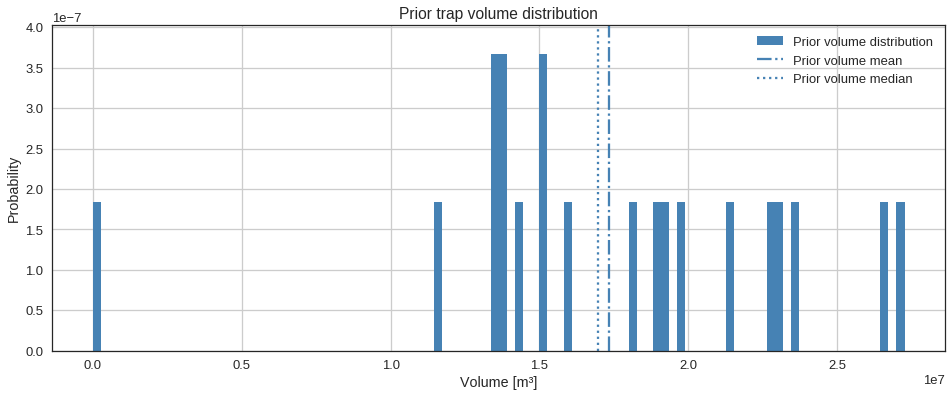

In [73]:
figsize(16, 6)

# Possibly mask away complete failures:
#volumes = max_volume_trace
#mask = volumes == 0
#masked_trace = volumes[~mask]

_hist1 = plt.hist(max_volume_trace, bins=100, normed=True, 
                  histtype="stepfilled",label="Prior volume distribution", color = "steelblue")
plt.vlines(max_volume_trace.mean(), 0, 1.1 * np.max(_hist1[0]), label="Prior volume mean", linestyles="-.", color = "steelblue")
plt.vlines(np.median(max_volume_trace), 0, 1.1 * np.max(_hist1[0]), label="Prior volume median", linestyles=":", color = "steelblue")
plt.title("Prior trap volume distribution")
plt.legend(loc="upper right")
#plt.xticks(np.arange(0, np.max(_hist1[0])+1, np.max(_hist1[0])/10))
plt.grid()
plt.ylim(0, 1.1 * np.max(_hist1[0]))
plt.xlabel("Volume [m³]")
plt.ylabel("Probability")

In [120]:
# INFORMATION ENTROPY FUNCTIONS
def compute_prob_lith(lith_blocks):
    """Blocks must be just the lith blocks!"""
    lith_id = np.unique(lith_blocks)
    lith_count = np.zeros_like(lith_blocks[0:len(lith_id)])
    for i, l_id in enumerate(lith_id):
        lith_count[i] = np.sum(lith_blocks == l_id, axis=0)
    lith_prob = lith_count / len(lith_blocks)
    return lith_prob


def calculate_ie_masked(lith_prob):
    ie = np.zeros_like(lith_prob[0])
    for l in lith_prob:
        pm = np.ma.masked_equal(l, 0)  # mask where layer prob is 0
        ie -= (pm * np.ma.log2(pm)).filled(0)
    return ie


def calculate_ie_total(ie, absolute=False):
    if absolute:
        return np.sum(ie)
    else:
        return np.sum(ie) / np.size(ie)

In [121]:
lith_blocks = []
for i in structural_model_trace[:]:
    #print(i[0][0])
    lith_blocks.append(i[0][0])

lith_prob = compute_prob_lith(lith_blocks)
i_entropy = calculate_ie_masked(lith_prob)

IndexError: index 20 is out of bounds for axis 0 with size 20

In [82]:
#CUSTOM LOSS FUNCTION
estimates_s = np.arange(0,60000000, 10000)

# weight factors
o = 1.25
o_f = 2
u_f = 1.5

# risk factor range
risks_s = np.arange(0.5, 1.6, 0.25)


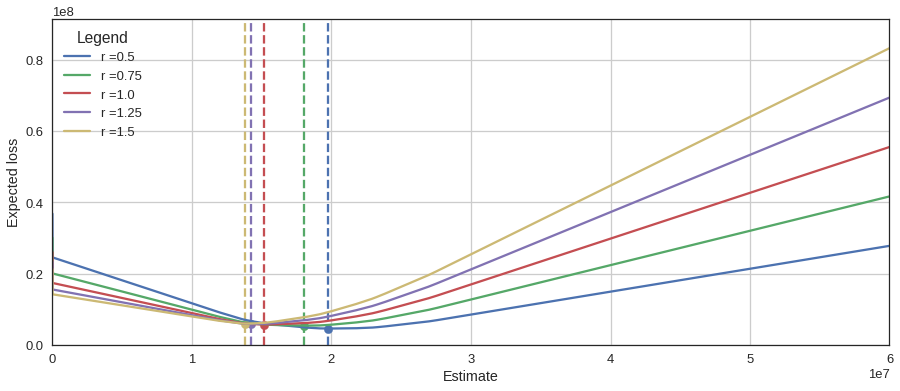

In [83]:
dm.expected_loss_plot(estimate_range=estimates_s,
                      true_s=max_volume_trace,
                      risk_range=risks_s,o=o,o_f=o_f,u_f=u_f)

In [84]:
### LIKELIHOOD FUNCTIONS

# THICKNESS LIKELIHOODS
#Additional information, updating with likelihoods
std1 = 30
std2 = 30
std3 = 30

@pymc.stochastic
def sec_res_th_likelihood(value = 0, sec_res_th=sec_res_th):
    return pymc.normal_like(sec_res_th, 150., 1./np.square(std1))

@pymc.stochastic
def seal_th_likelihood(value = 0, seal_th=seal_th):
    return pymc.normal_like(seal_th, 350., 1./np.square(std2))

@pymc.stochastic
def res_th_likelihood(value = 0, res_th=res_th):
    return pymc.normal_like(res_th, 250., 1./np.square(std3))


# SSF LIKELIHOOD
@pymc.stochastic
def SSF_likelihood(value = 0, SSF=structural_model[1]):
    return pymc.normal_like(SSF, 3, 1./np.square(0.3))


# JUXTAPOSITION AREA LIKELIHOOD (MOT USED)
#jux_mean = 150000
#jux_std = jux_mean/4
#
#@pymc.stochastic
#def jux_area_likelihood(value = 0, oja= over_jux_area):
#    return pymc.normal_like(over_jux_area, 150000., 1/np.square(jux_std))

In [85]:
likelihoods = "thickness" # choose which likelihoods to use: "thickness", "SSF" or "both"

if likelihoods == "thickness":
    # Model inclucing only thickness likelihoods
    model_L = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc,
                        fault_sealing, structural_model, 
                        res_th, seal_th, sec_res_th, res_th_likelihood, seal_th_likelihood, sec_res_th_likelihood])
elif likelihoods == "SSF":    
    # Model including only SSF likelihood
    model_L = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc,
                        fault_sealing, structural_model, 
                        res_th, seal_th, sec_res_th, SSF_likelihood])
elif likelihoods == "both":
    model_L = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc,
                        fault_sealing, structural_model, 
                        res_th, seal_th, sec_res_th, res_th_likelihood, seal_th_likelihood, 
                          sec_res_th_likelihood, SSF_likelihood])
else:
    print("Did not understand which likelihood functions to use.")

In [86]:
iterations=20

Z variations top to bottom: -50.5488423507 69.2531349981 -8.5865748829 85.8595006782
Fault offset variation: -21.1777746689


/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:80: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:56: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:67: UserWarning: Boolean Serie

SPILL POINT AT: [ 1360.           920.           874.62120056]
LEAK POINT AT: [ 640.          960.          860.21034241]
NUMBER OF TRAPS 4
Checking Section: 4
Checking Section: 14
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 14
Checking Section: 16
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 16
Checking Section: 19
Maximum trap volume: 22656000.0 m³
Z variations top to bottom: -35.3872524301 69.2531349981 -10.0004726873 85.8595006782
Fault offset variation: -21.1777746689
SPILL POINT AT: [ 1360.           920.           874.90608215]
LEAK POINT AT: [ 640.          960.          860.06614685]
NUMBER OF TRAPS 4
Checking Section: 4
Checking Section: 14
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 14
Checking Section: 16
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 16
Checking Section: 19
Maximum trap volume: 22656000.0 m³
Z variations top to bottom: -35.3872524

SPILL POINT AT: [ 1360.           920.           833.24943542]
LEAK POINT AT: [ 640.          960.          852.93525696]
NUMBER OF TRAPS 4
Checking Section: 4
Checking Section: 16
Checking Section: 11
No JP with any layer over seal.
TRAP: 11
Checking Section: 13
No JP with any layer over seal.
TRAP: 13
Maximum trap volume: 12928000.0 m³
 [-------          20%                  ] 4 of 20 complete in 201.5 secZ variations top to bottom: -18.8915830592 38.5286278102 -14.4533977376 141.462268703
Fault offset variation: -14.2372188733
SPILL POINT AT: [ 1360.           920.           868.47938538]
LEAK POINT AT: [ 640.          960.          852.91687012]
NUMBER OF TRAPS 4
Checking Section: 4
Checking Section: 14
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 14
Checking Section: 16
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 16
Checking Section: 19
Maximum trap volume: 20800000.0 m³
Z variations top to bottom: -58.7255691183 38.

SPILL POINT AT: [ 1320.           920.           868.05213928]
LEAK POINT AT: [ 640.          960.          851.67526245]
NUMBER OF TRAPS 4
Checking Section: 4
Checking Section: 14
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 14
Checking Section: 16
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 16
Checking Section: 19
Maximum trap volume: 20288000.0 m³
Z variations top to bottom: -18.8915830592 38.5286278102 -37.5023098485 160.113439223
Fault offset variation: -14.2372188733
Z variations top to bottom: -18.8915830592 57.098014328 -37.5023098485 160.113439223
Fault offset variation: -14.2372188733
SPILL POINT AT: [ 1320.          920.          868.1627655]
LEAK POINT AT: [ 640.          960.          857.04704285]
NUMBER OF TRAPS 4
Checking Section: 4
Checking Section: 13
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 13
Checking Section: 18
Checking Section: 15
Unable to calculate an adjacency 

NUMBER OF TRAPS 4
Checking Section: 4
Checking Section: 14
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 14
Checking Section: 16
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 16
Checking Section: 19
Maximum trap volume: 20032000.0 m³
Z variations top to bottom: -10.3917973319 -25.0365421193 -26.5191376469 166.702623321
Fault offset variation: -12.7127811287
SPILL POINT AT: [ 1360.           920.           867.03140259]
LEAK POINT AT: [ 640.         960.         847.1937561]
NUMBER OF TRAPS 4
Checking Section: 4
Checking Section: 14
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 14
Checking Section: 20
Checking Section: 16
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 16
Maximum trap volume: 20736000.0 m³
Z variations top to bottom: -10.3917973319 33.4765908538 -26.5191376469 166.702623321
Fault offset variation: -9.02236267782
SPILL POINT AT: [ 1360.           920.

NUMBER OF TRAPS 4
Checking Section: 4
Checking Section: 14
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 14
Checking Section: 20
Checking Section: 16
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 16
Maximum trap volume: 22848000.0 m³
Z variations top to bottom: -15.9083220796 19.9991515753 -40.5459146943 135.315487177
Fault offset variation: -21.7131249808
Z variations top to bottom: -15.9083220796 11.2779723144 -40.5459146943 135.315487177
Fault offset variation: -21.7131249808
SPILL POINT AT: [ 1360.           920.           876.31538391]
LEAK POINT AT: [ 640.         960.         856.2903595]
NUMBER OF TRAPS 4
Checking Section: 4
Checking Section: 14
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 14
Checking Section: 20
Checking Section: 16
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 16
Maximum trap volume: 22784000.0 m³
Z variations top to bottom: -15.9083220

SPILL POINT AT: [ 1360.           920.           876.39602661]
LEAK POINT AT: [ 640.          960.          856.64833069]
NUMBER OF TRAPS 4
Checking Section: 4
Checking Section: 14
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 14
Checking Section: 16
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 16
Checking Section: 19
Maximum trap volume: 22592000.0 m³
Z variations top to bottom: 24.8491950859 33.1081151148 -34.1892298035 176.287449062
Fault offset variation: -21.8449211215
SPILL POINT AT: [ 1360.         920.         876.302948]
LEAK POINT AT: [ 640.         960.         853.3807373]
NUMBER OF TRAPS 4
Checking Section: 4
Checking Section: 14
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 14
Checking Section: 16
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 16
Checking Section: 19
Maximum trap volume: 22528000.0 m³
Z variations top to bottom: 24.8491950859 14.4638

SPILL POINT AT: [ 1320.          920.          899.9369812]
LEAK POINT AT: [ 640.          960.          857.95196533]
NUMBER OF TRAPS 3
Checking Section: 4
Checking Section: 16
Adding 40.0 to throw, adjacency between 12 and 6
JP with layer over seal, checking SSF.
SSF = [ 332.31368361] / [ 292.31368361] = [ 1.1368393]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 16
Checking Section: 20
Maximum trap volume: 15872000.0 m³
 [-----------------90%--------------    ] 18 of 20 complete in 1081.6 secZ variations top to bottom: 24.8491950859 33.1081151148 -39.9132046801 135.315487177
Fault offset variation: -44.95551746
SPILL POINT AT: [ 1320.           920.           899.93995667]
LEAK POINT AT: [ 640.         960.         858.3984375]
NUMBER OF TRAPS 3
Checking Section: 4
Checking Section: 16
Adding 40.0 to throw, adjacency between 12 and 6
JP with layer over seal, checking SSF.
SSF = [ 334.62172792] / [ 294.62172792] = [ 1.13576731]
SSF in confidence range, complete 

SPILL POINT AT: [ 1360.           920.           902.07099915]
LEAK POINT AT: [ 640.          960.          858.38104248]
NUMBER OF TRAPS 3
Checking Section: 4
Checking Section: 16
Adding 80.0 to throw, adjacency between 12 and 6
JP with layer over seal, checking SSF.
SSF = [ 341.42180255] / [ 261.42180255] = [ 1.30601885]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 16
Checking Section: 19
Maximum trap volume: 16576000.0 m³
Z variations top to bottom: 24.2902117233 29.4198791856 -59.2479208923 135.315487177
Fault offset variation: -37.6728247998
SPILL POINT AT: [ 1320.           920.           892.81478882]
LEAK POINT AT: [ 640.          960.          861.70417786]
NUMBER OF TRAPS 3
Checking Section: 4
Checking Section: 15
Adding 40.0 to throw, adjacency between 11 and 6
JP with layer over seal, checking SSF.
SSF = [ 350.26820821] / [ 310.26820821] = [ 1.12892072]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 15
Checking Section: 19
Maxim

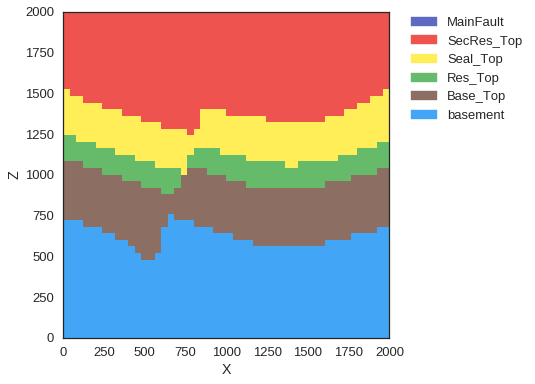

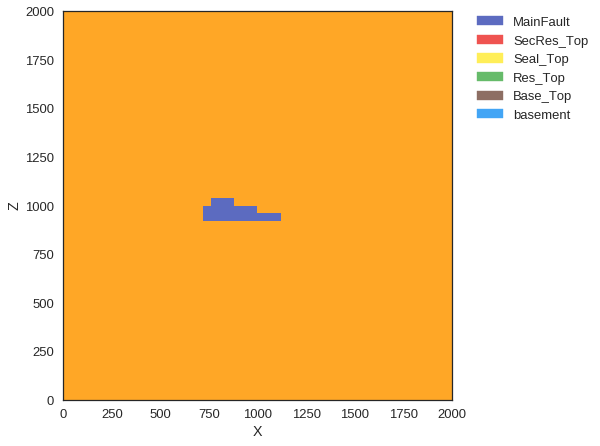

In [87]:
M_L = pymc.MCMC(model_L)
#M_L = pymc.MCMC(model_L,db= "hdf5" , dbname= "D:/PyMC_DataBase/post_model_300_30-050_10-400_40_1000iter50burn.hdf5")
M_L.sample(iter=iterations, burn=0)

In [47]:
#M_L.db.commit()
#M_L.db.close()

In [116]:
res_top_unc_trace_L = M_L.trace('z_unc_res_top')[:]
offset_unc_trace_L = M_L.trace('offset_unc')[:]
interp_trace_L = M_L.trace('interp_unc')[:]
#over_jux_area_trace_L = M_L.trace('over_jux_area')[:] 

fw_res_th_trace_L = M_L.trace('res_th')[:]
fw_seal_th_trace_L = M_L.trace('seal_th')[:]
fw_sec_res_th_trace_L = M_L.trace('sec_res_th')[:]

structural_model_trace_L = M_L.trace('structural_model')[:]
max_volume_trace_L = structural_model_trace_L[:,2]
SSF_trace_L = structural_model_trace_L[:,4]
trap_control_trace_L = structural_model_trace_L[:,5]

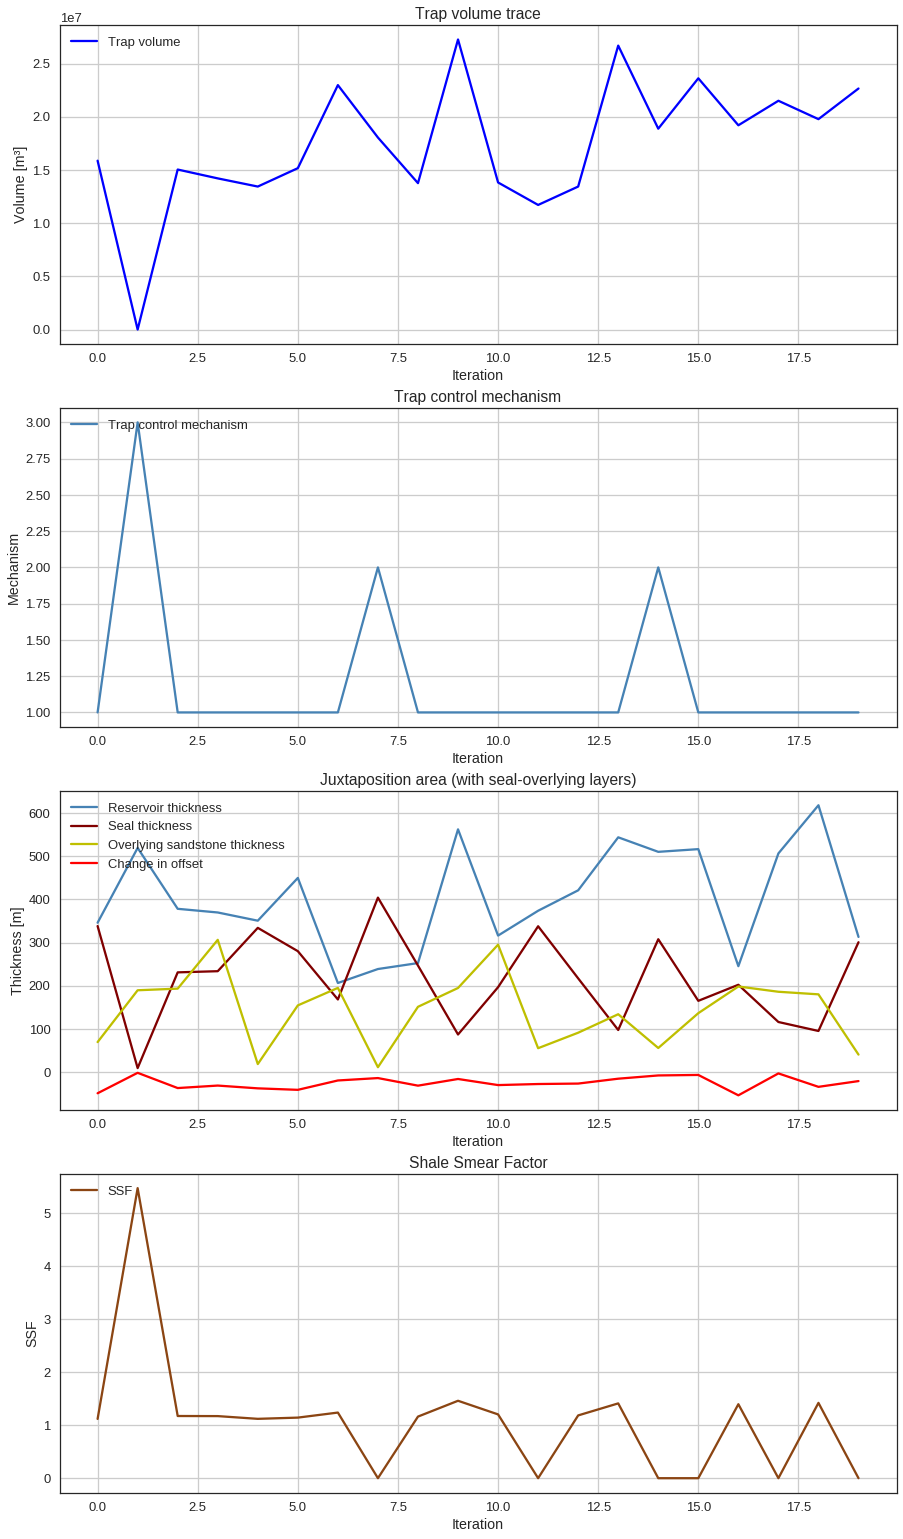

In [89]:
figsize(15,27)
fig, ax = plt.subplots(4, 1)

ax[0].plot(max_volume_trace, color='b', label='Trap volume')
ax[0].set_title('Trap volume trace')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Volume [m³]')
ax[0].legend(loc="upper left")
ax[0].grid()

ax[1].plot(trap_control_trace, color='steelblue', label='Trap control mechanism')
ax[1].set_title('Trap control mechanism')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Mechanism')
ax[1].legend(loc="upper left")
ax[1].grid()

ax[2].plot(fw_res_th_trace, color='steelblue', label='Reservoir thickness')
ax[2].plot(fw_seal_th_trace, color='maroon', label='Seal thickness')
ax[2].plot(fw_sec_res_th_trace, color='y', label='Overlying sandstone thickness')
ax[2].plot(offset_unc_trace*rescale_f, color='r', label='Change in offset')
ax[2].set_title('Juxtaposition area (with seal-overlying layers)')
ax[2].set_xlabel('Iteration')
ax[2].set_ylabel('Thickness [m]')
ax[2].legend(loc="upper left")
ax[2].grid()

ax[3].plot(SSF_trace, color='saddlebrown', label='SSF')
ax[3].set_title('Shale Smear Factor')
ax[3].set_xlabel('Iteration')
ax[3].set_ylabel('SSF')
ax[3].legend(loc="upper left")
ax[3].grid()

#ax[4].plot(over_jux_area_trace, color='g', label='Juxtaposition area')
#ax[4].set_title('Juxtaposition area (with seal-overlying layers)')
#ax[4].set_xlabel('Iteration')
#ax[4].set_ylabel('Area [m²]')
#ax[4].legend(loc="upper left")
#ax[4].grid()

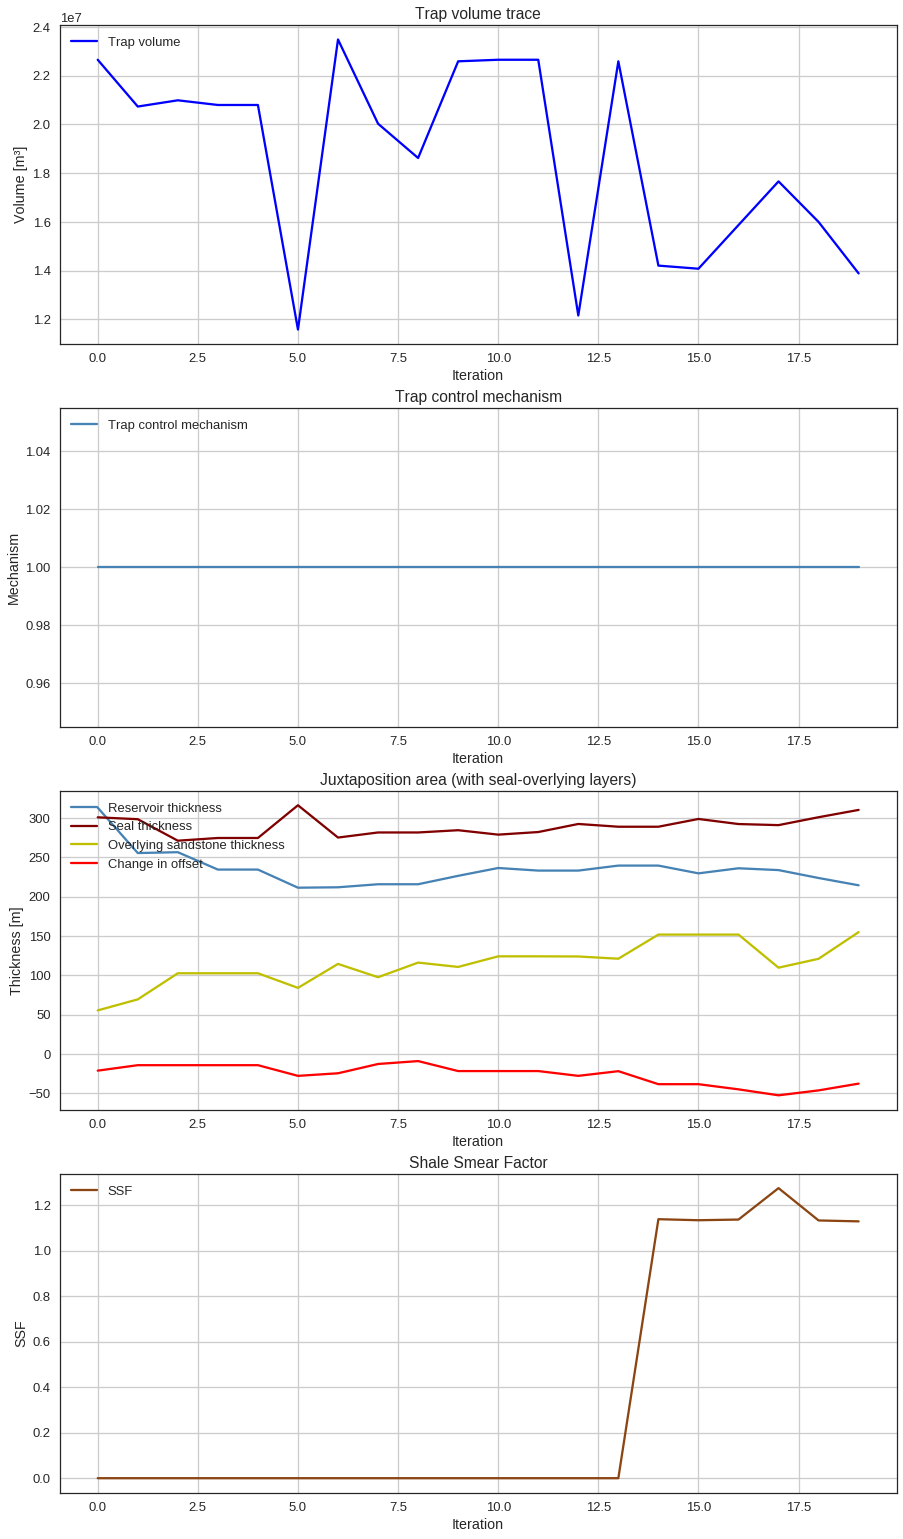

In [90]:
figsize(15,27)
fig, ax = plt.subplots(4, 1)

ax[0].plot(max_volume_trace_L, color='b', label='Trap volume')
ax[0].set_title('Trap volume trace')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Volume [m³]')
ax[0].legend(loc="upper left")
ax[0].grid()

ax[1].plot(trap_control_trace_L, color='steelblue', label='Trap control mechanism')
ax[1].set_title('Trap control mechanism')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Mechanism')
ax[1].legend(loc="upper left")
ax[1].grid()

ax[2].plot(fw_res_th_trace_L, color='steelblue', label='Reservoir thickness')
ax[2].plot(fw_seal_th_trace_L, color='maroon', label='Seal thickness')
ax[2].plot(fw_sec_res_th_trace_L, color='y', label='Overlying sandstone thickness')
ax[2].plot(offset_unc_trace_L*rescale_f, color='r', label='Change in offset')
ax[2].set_title('Juxtaposition area (with seal-overlying layers)')
ax[2].set_xlabel('Iteration')
ax[2].set_ylabel('Thickness [m]')
ax[2].legend(loc="upper left")
ax[2].grid()

ax[3].plot(SSF_trace_L, color='saddlebrown', label='SSF')
ax[3].set_title('Shale Smear Factor')
ax[3].set_xlabel('Iteration')
ax[3].set_ylabel('SSF')
ax[3].legend(loc="upper left")
ax[3].grid()

#ax[4].plot(over_jux_area_trace_L, color='g', label='Juxtaposition area')
#ax[4].set_title('Juxtaposition area (with seal-overlying layers)')
#ax[4].set_xlabel('Iteration')
#ax[4].set_ylabel('Area [m²]')
#ax[4].legend(loc="upper left")
#ax[4].grid()

In [119]:
lith_blocks = []
for i in structural_model_trace_L[:]:
    #print(i[0][0])
    lith_blocks.append(i[0][0])

lith_prob = compute_prob_lith(lith_blocks)
i_entropy = calculate_ie_masked(lith_prob)

IndexError: index 20 is out of bounds for axis 0 with size 20

NameError: name 'i_entropy' is not defined

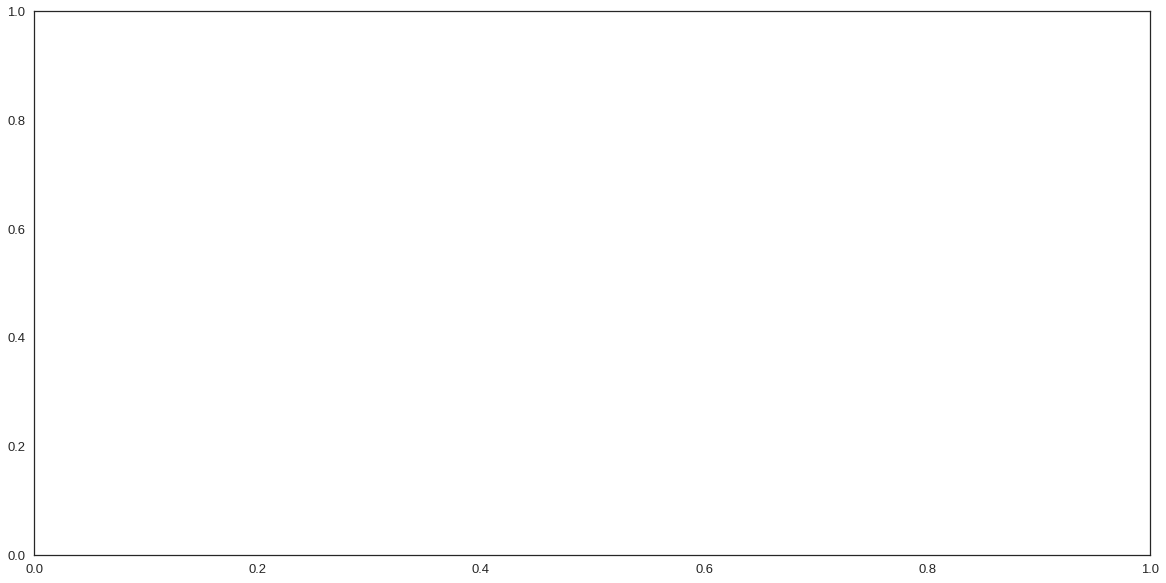

In [104]:
figsize(20,10)
fig, ax = plt.subplots(1)
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 
plt.imshow(i_entropy.reshape(resolution,resolution,resolution)[:,resolution/2,:].T, origin="lower", cmap="viridis")
plt.colorbar()

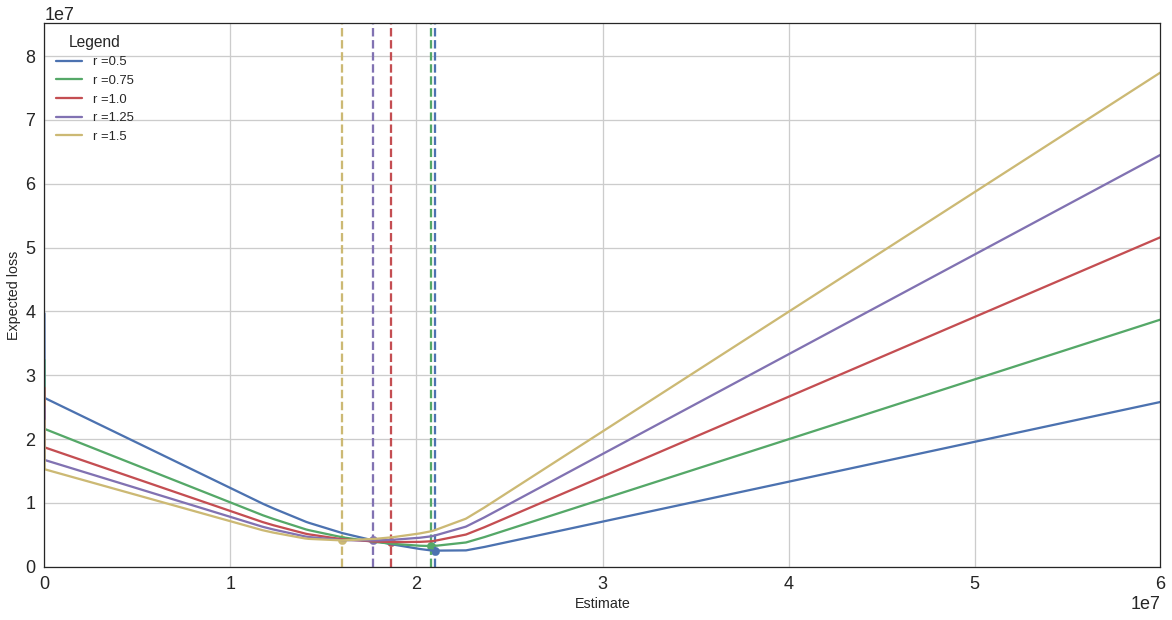

In [109]:
dm.expected_loss_plot(estimate_range=estimates_s, true_s=max_volume_trace_L,
                     risk_range=risks_s, o=o, o_f=o_f, u_f=u_f)

In [54]:
# FOR EXPORTING TO USE IN PARAVIEW:
export = False

if export:
    counter = 0
    for i in structural_model_trace[:]:
        counter+=1
        #print(np.ascontiguousarray(i[3]))
        gp.export_vtk_rectilinear(geo_data, np.ascontiguousarray(i[3]), path="./output_data/trap_volumes/14_11-TRAP_100iterUNC_PRIORonly_%s" % (counter))
        gp.export_vtk_rectilinear(geo_data, np.ascontiguousarray(i[0][0]), path="./output_data/lith_blocks/14_11-LITH_100iterUNC_PRIORonly_%s" % (counter))

In [ ]:
#import graphviz
#pymc.graph.dag(model)

In [ ]:
#sys.path.append("/home/bl9/Theses/Risk\ analysis/Notebooks")
#graph = pymc.graph.graph(model)
#graph.write_png()